# 🚩 Problem Statement: Predict the likeliness of a patient's diagnosis to be diabetic or not. 
- Our approach to this problem is going to be an unsupervised one, as we dont have a target / class variable.
- The idea is to draw patterns from the clusters to predict the likelihood of the patient having chronic illness or not
---

After running into space issues with the rows that were created, we are shifting our approach to supervised one. where we create the outcome(target class)



- Members:
    - BHATT Ragi


### ✍️ Rough Plan: [Estimate: 6 weeks]

 - Clean the data
    - Handle Missing Values
    - Handle Null values
    - Remove noise (irrelevant labels)
- Preprocessing the data:
    - Feature extraction
    - Feature Importance
    - Feature selection
    - Handle time series
    - Handle categorical, numerical data 
- Exploratory Analysis 
    - Plots of features against predicted class distribution
- Train, Test, Validation data building

- Compute accuracy, precision / recall scores
- Model refinement (adjusting hyperparameters, checking the generalization of the model)
- Model improvement scores, discusison on further plots and improvements

In [2]:
#Import all necessary libraries
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import imblearn
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import gc
import tqdm
import re
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt
import plotly
import matplotlib.gridspec as gridspec
import sys

In [4]:
%reload_ext autoreload
%autoreload 2

# Set precision for pd and np (np: suppress also sci notation)
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = "{:,.4g}".format

print(sklearn.__version__)  # Version tested on sklearn.__version__ == 1.1.3

1.2.2


## 1. Data Loading
- We will load the data here and explore the data dimensions, columns and null values in the dataset.

In [5]:
entire_df = pd.read_csv('Observations.csv')

In [6]:
work_df = entire_df.copy()

We will work with work_df in this notebook to preserve the initial original medical data, just in case we need to reference it later or take some values from there.


In [7]:
def stats(data):
    #check the shaape of the data
    print("The shape of the data is: ", data.shape)
    #number of rows
    print("The number of rows is: ", data.shape[0])
    #number of columns
    print("The number of columns is: ", data.shape[1])
    #check the data types
    print("The data types are: ", data.dtypes)
    #check the null values
    print("The null values are: ", data.isnull().sum())
    #check the number of unique values
    print("The number of unique values are: ", data.nunique())
    #check the number of categorical columns in the df
    print("The number of categorical columns are: ", len(data.select_dtypes(include = "object").columns))
    #check the number of numerical columns in the df
    print("The number of numerical columns are: ", len(data.select_dtypes(include = ["int64", "float64"]).columns))
    #check the descriptive statistics
    print('The Descriptive statistics are: ', data.describe().T)
    return

In [8]:
stats(work_df)

The shape of the data is:  (8994161, 77)
The number of rows is:  8994161
The number of columns is:  77
The data types are:  ID                     int64
DiagnosisGroup        object
DiagnosisPriority    float64
DiagnosisTime         object
Encounter              int64
                      ...   
Expr14                object
Gender_Name           object
Expr15                object
EnteredOnChar        float64
Expr16                object
Length: 77, dtype: object
The null values are:  ID                         0
DiagnosisGroup             0
DiagnosisPriority    2026338
DiagnosisTime              0
Encounter                  0
                      ...   
Expr14                    12
Gender_Name               12
Expr15               1182740
EnteredOnChar             12
Expr16               4990339
Length: 77, dtype: int64
The number of unique values are:  ID                   282769
DiagnosisGroup         1252
DiagnosisPriority        19
DiagnosisTime         87248
Encounter          

In [9]:
#print the columns in the df

for col in work_df.columns:
    print(col)

ID
DiagnosisGroup
DiagnosisPriority
DiagnosisTime
Encounter
EncounterNumber
EnteredAt
EnteredOn
IsPrimary
LastUpdated
Patient
TagFacility
Diagnosis_Code
Diagnosis_Description
Diagnosis_SDACodingStandard
DiagnosisType_Code
DiagnosisType_Description
Status_Code
Status_Description
ID.1
AnalysisTime
Encounter.1
LabResult
LastUpdated.1
ObservationTime
ObservationValueType
HSAAOrder
Patient.1
ResultInterpretation
ResultNormalRange
ResultRawValue
ResultTime
ResultValue
ResultValueUnits
TagFacility.1
TestItemStatus
PerformedAt_Code
PerformedAt_Description
PerformedAt_SDACodingStandard
TestItemCode_Code
TestItemCode_Description
TestItemCode_IsNumeric
ID.2
Encounter.2
EncounterNumber.1
LastUpdated.2
ObservationRawValue
ObservationTime.1
ObservationValue
ObservationValueType.1
Patient.2
Tag
TagFacility.2
ObservationCode_Code
ObservationCode_Description
ObservationCode_ObservationValueUnits_Code
ObservationCode_ObservationValueUnits_Description
ObservationCode_SDACodingStandard
Expr1
Expr2
Expr3
E

In [10]:
#add a new column to the df where all the values are 1
work_df['Target'] = 1

In [11]:
#Make a new column for number of patient observations by grouping the patient id
work_df['NumberObservation'] = work_df.groupby('Patient')['Patient'].transform('count')

In [12]:
work_df['NumberObservation'].value_counts()


NumberObservation
16    181888
24    180576
48    150432
32    146208
8     138240
       ...  
53        53
43        43
41        41
37        37
31        31
Name: count, Length: 655, dtype: int64

In [13]:
#number of distinct patients in the dataset
print("The number of distinct patients in the dataset are: ", work_df['Patient'].nunique())


The number of distinct patients in the dataset are:  121211


In [14]:
#print the number observation column by sorting the values descending
for i in work_df['NumberObservation'].sort_values(ascending = False).unique():
    print(i)


25272
19440
14040
13824
13552
13440
12096
10800
10296
8640
8320
8064
7840
7776
7168
6552
6384
6160
6048
5832
5616
5472
5376
5184
5120
4992
4752
4608
4536
4480
4368
4320
4160
4104
4032
3920
3888
3848
3840
3744
3696
3648
3640
3584
3500
3472
3456
3264
3248
3240
3168
3150
3120
3096
3080
3072
3042
3024
2952
2928
2904
2880
2816
2760
2752
2736
2728
2720
2688
2646
2640
2624
2600
2592
2560
2530
2520
2496
2484
2480
2464
2448
2432
2430
2408
2400
2392
2380
2376
2368
2352
2340
2322
2304
2296
2295
2280
2268
2256
2240
2232
2214
2208
2176
2160
2142
2128
2112
2107
2090
2080
2072
2064
2048
2040
2016
2014
2000
1980
1974
1968
1953
1944
1936
1920
1914
1890
1872
1860
1856
1848
1840
1824
1820
1806
1800
1794
1792
1785
1782
1776
1771
1764
1760
1736
1728
1722
1720
1692
1680
1674
1672
1664
1656
1650
1645
1640
1638
1632
1624
1620
1600
1596
1595
1584
1575
1568
1560
1554
1548
1540
1536
1520
1519
1518
1512
1504
1500
1496
1495
1488
1480
1476
1472
1470
1458
1456
1440
1428
1408
1404
1400
1392
1386
1380
1372
1368
1365
1

In [15]:
#print the highest number of observations for a patient
print("The highest number of observations for a patient is: ", work_df['NumberObservation'].max())

The highest number of observations for a patient is:  25272


In [16]:
stats(work_df)

The shape of the data is:  (8994161, 79)
The number of rows is:  8994161
The number of columns is:  79
The data types are:  ID                     int64
DiagnosisGroup        object
DiagnosisPriority    float64
DiagnosisTime         object
Encounter              int64
                      ...   
Expr15                object
EnteredOnChar        float64
Expr16                object
Target                 int64
NumberObservation      int64
Length: 79, dtype: object
The null values are:  ID                         0
DiagnosisGroup             0
DiagnosisPriority    2026338
DiagnosisTime              0
Encounter                  0
                      ...   
Expr15               1182740
EnteredOnChar             12
Expr16               4990339
Target                     0
NumberObservation          0
Length: 79, dtype: int64
The number of unique values are:  ID                   282769
DiagnosisGroup         1252
DiagnosisPriority        19
DiagnosisTime         87248
Encounter          

In [57]:
for col in work_df.columns:
    print(col)

ID
DiagnosisGroup
DiagnosisPriority
DiagnosisTime
Encounter
EncounterNumber
EnteredAt
EnteredOn
IsPrimary
LastUpdated
Patient
TagFacility
Diagnosis_Code
Diagnosis_Description
Diagnosis_SDACodingStandard
DiagnosisType_Code
DiagnosisType_Description
Status_Code
Status_Description
ID.1
AnalysisTime
Encounter.1
LabResult
LastUpdated.1
ObservationTime
ObservationValueType
HSAAOrder
Patient.1
ResultInterpretation
ResultNormalRange
ResultRawValue
ResultTime
ResultValue
ResultValueUnits
TagFacility.1
TestItemStatus
PerformedAt_Code
PerformedAt_Description
PerformedAt_SDACodingStandard
TestItemCode_Code
TestItemCode_Description
TestItemCode_IsNumeric
ID.2
Encounter.2
EncounterNumber.1
LastUpdated.2
ObservationRawValue
ObservationTime.1
ObservationValue
ObservationValueType.1
Patient.2
Tag
TagFacility.2
ObservationCode_Code
ObservationCode_Description
ObservationCode_ObservationValueUnits_Code
ObservationCode_ObservationValueUnits_Description
ObservationCode_SDACodingStandard
Expr1
Expr2
Expr3
E

In [17]:
#Make another dataframe with distinct 20 K patients and get all the other features from the original df
diabetes_df = work_df.groupby('Patient').last().reset_index()

In [18]:
diabetes_df.shape

(121211, 79)

In [19]:
#check the number of distinct patients in the new df
print("The number of distinct patients in the new df are: ", diabetes_df['Patient'].nunique())

The number of distinct patients in the new df are:  121211


In [20]:
diabetes_df.head()

Patient        ID DiagnosisGroup  DiagnosisPriority   
0    59268  17225607            E07                NaN  \
1    67031   7322582            R14                NaN   
2    68424   6003308            J05                NaN   
3    77992  13687881            R79                NaN   
4    82896       627            K29                NaN   

             DiagnosisTime  Encounter  EncounterNumber  EnteredAt   
0  2023-05-21 13:48:00.000   16500340          5506856         47  \
1  2022-11-09 21:28:00.000   10374855          5304909         47   
2  2022-10-08 03:27:00.000    9264777          5266710         47   
3  2023-03-16 22:02:00.000   14507398  S60O23030006816        534   
4  2022-02-22 21:25:53.000        239          5051887         47   

                 EnteredOn  IsPrimary  ...  Expr12  Expr13   
0  2023-05-21 13:48:00.000          0  ...    None     UAE  \
1  2022-11-09 21:28:00.000          0  ...    None     UAE   
2  2022-10-08 03:27:00.000          0  ...    None     UAE   
3  2023-03-16 22:02:00.000          0  ...  MAMZER     ARE   
4  2022-02-22 21:25:53.000          0  ...    None     UAE   

  Citizenship_Description Expr14 Gender_Name Expr15 EnteredOnChar     Expr16   
0    UNITED ARAB EMIRATES      F      Female      M     2.022e+07       None  \
1    UNITED ARAB EMIRATES      F      Female      M     2.021e+07       None   
2    UNITED ARAB EMIRATES      M        Male      B     2.022e+07  NOXXXXXXX   
3                 Emirati      F      Female      U     2.023e+07  EDXXXXXXX   
4    UNITED ARAB EMIRATES      M        Male      M     2.022e+07  N@XXXXXXX   

  Target  NumberObservation  
0      1                 70  
1      1                  7  
2      1                  8  
3      1                  6  
4      1                  6  

[5 rows x 79 columns]

## Consider the diabetes_df dataset here

In [21]:
diabetes_df = pd.read_csv('diabetes_df.csv')

In [22]:
for col in diabetes_df.columns:
    print(col)


Patient
DiagnosisGroup
Diagnosis_Code
Diagnosis_Description
ResultInterpretation
ResultValue
ResultValueUnits
TestItemCode_Description
ObservationValue
ObservationCode_Description
ObservationCode_ObservationValueUnits_Code
Expr5
Citizenship_Description
Gender_Name
Target
NumberObservation


In [23]:
diabetes_df.drop(['DiagnosisGroup', 'NumberObservation'], axis = 1, inplace = True)

In [24]:
#rename the columns
diabetes_df.rename(columns = {'Expr5': 'Age', 'Gender_Name': 'Gender', 'Citizenship_Description': 'Citizen'}, inplace = True)

In [25]:
#Category Columns
cat_col = ['Diagnosis_Code', 'ResultInterpretation', 'ResultValueUnits', 'TestItemCode_Description', 'Gender', 'Age']

In [26]:
#Numerical Columns
num_col = ['ResultValue', 'ObservationValue']

In [27]:
#Binary Columns 
target_col = ['Target']

In [28]:
#check the number of unique values in each column
for col in diabetes_df.columns:
    print(col, diabetes_df[col].nunique())
    

Patient 121211
Diagnosis_Code 4883
Diagnosis_Description 5432
ResultInterpretation 9
ResultValue 12882
ResultValueUnits 284
TestItemCode_Description 2826
ObservationValue 3467
ObservationCode_Description 12
ObservationCode_ObservationValueUnits_Code 7
Age 109
Citizen 441
Gender 3
Target 1


In [29]:
#display the columns with null values
def null_columns(data):
    null_df = pd.DataFrame(data.isnull().sum(), columns = ["Null Values"])
    null_df["% Null Values"] = round((null_df["Null Values"]/len(data))*100, 2)
    return null_df[null_df["Null Values"] > 0]


In [30]:
#sort in descending order
null_columns(diabetes_df).sort_values(by = "Null Values", ascending = False)

Null Values  % Null Values
ResultValueUnits                                  23598          19.47
ResultInterpretation                              17029          14.05
ObservationCode_ObservationValueUnits_Code           15           0.01
Age                                                   1              0
Citizen                                               1              0
Gender                                                1              0

In [31]:
#one hot encoding for the categorical columns
def one_hot(data, col):
    return pd.get_dummies(data, columns = col, drop_first = True)

#label encoding for the ordinal columns
def label_encode(data, col):
    for i in col:
        data[i] = data[i].astype('category').cat.codes
    return data


In [32]:
#function to fill the null values
def fill_null(data, col):
    for i in col:
        data[i].fillna(data[i].mode()[0], inplace = True)
    return data

#function to fill the null values
def fill_null_mean(data, col):
    for i in col:
        data[i].fillna(data[i].mean(), inplace = True)
    return data

#function to fill the null values
def fill_null_median(data, col):
    for i in col:
        data[i].fillna(data[i].median(), inplace = True)
    return data


In [33]:
diabetes_df

Patient Diagnosis_Code   
0         59268          E07.9  \
1         67031          R14.3   
2         68424          J05.0   
3         77992         R79.89   
4         82896         K29.00   
...         ...            ...   
121206  3224064          L72.3   
121207  3224181          Z36.4   
121208  3224376       S65.201A   
121209  3224424        M23.332   
121210  3224654          D64.9   

                                    Diagnosis_Description   
0                        Disorder of thyroid, unspecified  \
1                                              Flatulence   
2                    Acute obstructive laryngitis (croup)   
3       Other specified abnormal findings of blood che...   
4                        Acute gastritis without bleeding   
...                                                   ...   
121206                                     Sebaceous cyst   
121207  Encounter for antenatal screening for fetal gr...   
121208  Unspecified injury of superficial palmar arch ...   
121209  Other meniscus derangements, other medial meni...   
121210                                Anemia, unspecified   

       ResultInterpretation ResultValue  ResultValueUnits   
0                    Normal  28/08/2022             mg/dl  \
1                    Normal      <0.100  mIU/ml\X0D\\X0A\   
2                    Normal         2.5              mg/L   
3                    Normal         6.3                 %   
4                    Normal        19.4               U/L   
...                     ...         ...               ...   
121206               Normal    NEGATIVE              ug/g   
121207                  NaN    NEGATIVE               NaN   
121208               Normal           9             IU/mL   
121209               Normal       Clear               NaN   
121210               Normal        32.4             gm/dL   

                                 TestItemCode_Description ObservationValue   
0                                                    DATE               96  \
1                                       BETA H C G LEVELS               20   
2                                      C Reactive Protein             16.3   
3                                                  HbA1C.              152   
4                                              SGPT / ALT               85   
...                                                   ...              ...   
121206                        * H. PYLORI ANTIGEN (STOOL)             64.5   
121207  Coomb's test (Indirect) (Antibody screening), ...              150   
121208  Microsomal antibodies (eg, thyroid or liver-ki...               70   
121209                                         Appearance            30.93   
121210                                             * MCHC               74   

       ObservationCode_Description ObservationCode_ObservationValueUnits_Code   
0          Systolic Blood Pressure                                       mmHg  \
1                 Respiratory Rate                                        bpm   
2                           Weight                                         kg   
3                           Height                                         cm   
4                           Weight                                         kg   
...                            ...                                        ...   
121206                      Weight                                         kg   
121207                      Height                                         cm   
121208    Diastolic Blood Pressure                                       mmHg   
121209       BMI (Body Mass Index)                                      kg/m2   
121210                      Weight                                         kg   

        Age               Citizen  Gender  Target  
0        41  UNITED ARAB EMIRATES  Female       1  
1        38  UNITED ARAB EMIRATES  Female       1  
2         3  UNITED ARAB EMIRATES    Male       1  
3        70    

In [34]:
def fill_missing_values(diabetes_df):
    d_df_num = diabetes_df[num_col]
    d_df_cat = diabetes_df[cat_col]

    fill_df_num = fill_null_mean(d_df_num, num_col)
    fill_df_cat = fill_null(d_df_cat, cat_col)

    diabetes_df = pd.concat([fill_df_num.fillna(fill_df_num), fill_df_cat.fillna(fill_df_cat)], axis = 1)
    return diabetes_df



In [35]:
#Display the values of the numerical columns
def display_num(data,col):
    for i in col:
        print(i, data[i].unique())
    return


In [36]:
display_num(diabetes_df, num_col)

ResultValue ['28/08/2022' '<0.100' '2.5' ... '287.4' '462.4' '249.98']
ObservationValue ['96' '20' '16.3' ... '24.66834' '47.02' '114.68']


In [37]:
#Since the values of the numerical columns are not in the same scale, we need to scale them
def scale(data, col):
    scaler = StandardScaler()
    data[col] = scaler.fit_transform(data[col])
    return data

In [38]:
#We will first split the ObservationCode_Description into different columns based on the entries in the column
#For example: Height will be split into a new column and the values will be filled in the new column

#function to split the column

def split_col(data):
    data['Height (in cm)'] = data.apply(lambda x: x['ObservationValue'] if 'Height' in x['ObservationCode_Description'] else np.nan, axis=1)
    data['Weight (in kg)'] = data.apply(lambda x: x['ObservationValue'] if 'Weight' in x['ObservationCode_Description'] else np.nan, axis=1)
    data['BMI in kg/m2'] = data.apply(lambda x: x['ObservationValue'] if 'BMI' in x['ObservationCode_Description'] else np.nan, axis=1)
    data['Body Temperature (in DegC)'] = data.apply(lambda x: x['ObservationValue'] if 'Body Temperature' in x['ObservationCode_Description'] else np.nan, axis=1)
    data['Diastolic Blood Pressure in mmHg'] = data.apply(lambda x: x['ObservationValue'] if 'Diastolic Blood Pressure' in x['ObservationCode_Description'] else np.nan, axis=1)
    data['Systolic Blood Pressure in mmHg'] = data.apply(lambda x: x['ObservationValue'] if 'Systolic Blood Pressure' in x['ObservationCode_Description'] else np.nan, axis=1)
    data['Heart Rate in bpm'] = data.apply(lambda x: x['ObservationValue'] if 'Heart Rate' in x['ObservationCode_Description'] else np.nan, axis=1)
    data['Respiratory Rate in bpm'] = data.apply(lambda x: x['ObservationValue'] if 'Respiratory Rate' in x['ObservationCode_Description'] else np.nan, axis=1)   

    return data

#Here the lambda function, checks if the ObservationCode_Description contains the string 'Height' and if it does, it will return the value in the ObservationValue column


In [39]:
split_col(diabetes_df)

Patient Diagnosis_Code   
0         59268          E07.9  \
1         67031          R14.3   
2         68424          J05.0   
3         77992         R79.89   
4         82896         K29.00   
...         ...            ...   
121206  3224064          L72.3   
121207  3224181          Z36.4   
121208  3224376       S65.201A   
121209  3224424        M23.332   
121210  3224654          D64.9   

                                    Diagnosis_Description   
0                        Disorder of thyroid, unspecified  \
1                                              Flatulence   
2                    Acute obstructive laryngitis (croup)   
3       Other specified abnormal findings of blood che...   
4                        Acute gastritis without bleeding   
...                                                   ...   
121206                                     Sebaceous cyst   
121207  Encounter for antenatal screening for fetal gr...   
121208  Unspecified injury of superficial palmar arch ...   
121209  Other meniscus derangements, other medial meni...   
121210                                Anemia, unspecified   

       ResultInterpretation ResultValue  ResultValueUnits   
0                    Normal  28/08/2022             mg/dl  \
1                    Normal      <0.100  mIU/ml\X0D\\X0A\   
2                    Normal         2.5              mg/L   
3                    Normal         6.3                 %   
4                    Normal        19.4               U/L   
...                     ...         ...               ...   
121206               Normal    NEGATIVE              ug/g   
121207                  NaN    NEGATIVE               NaN   
121208               Normal           9             IU/mL   
121209               Normal       Clear               NaN   
121210               Normal        32.4             gm/dL   

                                 TestItemCode_Description ObservationValue   
0                                                    DATE               96  \
1                                       BETA H C G LEVELS               20   
2                                      C Reactive Protein             16.3   
3                                                  HbA1C.              152   
4                                              SGPT / ALT               85   
...                                                   ...              ...   
121206                        * H. PYLORI ANTIGEN (STOOL)             64.5   
121207  Coomb's test (Indirect) (Antibody screening), ...              150   
121208  Microsomal antibodies (eg, thyroid or liver-ki...               70   
121209                                         Appearance            30.93   
121210                                             * MCHC               74   

       ObservationCode_Description ObservationCode_ObservationValueUnits_Code   
0          Systolic Blood Pressure                                       mmHg  \
1                 Respiratory Rate                                        bpm   
2                           Weight                                         kg   
3                           Height                                         cm   
4                           Weight                                         kg   
...                            ...                                        ...   
121206                      Weight                                         kg   
121207                      Height                                         cm   
121208    Diastolic Blood Pressure                                       mmHg   
121209       BMI (Body Mass Index)                                      kg/m2   
121210                      Weight                                         kg   

        ...  Gender Target Height (in cm)  Weight (in kg) BMI in kg/m2   
0       ...  Female      1            NaN             NaN          NaN  \
1       ...  Female      1            NaN             NaN          NaN   
2

In [40]:
diabetes_df.head()

Patient Diagnosis_Code                              Diagnosis_Description   
0    59268          E07.9                   Disorder of thyroid, unspecified  \
1    67031          R14.3                                         Flatulence   
2    68424          J05.0               Acute obstructive laryngitis (croup)   
3    77992         R79.89  Other specified abnormal findings of blood che...   
4    82896         K29.00                   Acute gastritis without bleeding   

  ResultInterpretation ResultValue  ResultValueUnits TestItemCode_Description   
0               Normal  28/08/2022             mg/dl                     DATE  \
1               Normal      <0.100  mIU/ml\X0D\\X0A\        BETA H C G LEVELS   
2               Normal         2.5              mg/L       C Reactive Protein   
3               Normal         6.3                 %                   HbA1C.   
4               Normal        19.4               U/L               SGPT / ALT   

  ObservationValue ObservationCode_Description   
0               96     Systolic Blood Pressure  \
1               20            Respiratory Rate   
2             16.3                      Weight   
3              152                      Height   
4               85                      Weight   

  ObservationCode_ObservationValueUnits_Code  ...  Gender Target   
0                                       mmHg  ...  Female      1  \
1                                        bpm  ...  Female      1   
2                                         kg  ...    Male      1   
3                                         cm  ...  Female      1   
4                                         kg  ...    Male      1   

  Height (in cm)  Weight (in kg) BMI in kg/m2 Body Temperature (in DegC)   
0            NaN             NaN          NaN                        NaN  \
1            NaN             NaN          NaN                        NaN   
2            NaN            16.3          NaN                        NaN   
3            152             NaN          NaN                        NaN   
4            NaN              85          NaN                        NaN   

  Diastolic Blood Pressure in mmHg Systolic Blood Pressure in mmHg   
0                              NaN                              96  \
1                              NaN                             NaN   
2                              NaN                             NaN   
3                              NaN                             NaN   
4                              NaN                             NaN   

  Heart Rate in bpm Respiratory Rate in bpm  
0               NaN                     NaN  
1               NaN                      20  
2               NaN                     NaN  
3               NaN                     NaN  
4               NaN                     NaN  

[5 rows x 22 columns]

In [41]:
diabetes_df.drop(['ObservationCode_Description', 'ObservationValue', 'ObservationCode_ObservationValueUnits_Code'], axis = 1, inplace = True)

In [42]:
diabetes_df.head()

Patient Diagnosis_Code                              Diagnosis_Description   
0    59268          E07.9                   Disorder of thyroid, unspecified  \
1    67031          R14.3                                         Flatulence   
2    68424          J05.0               Acute obstructive laryngitis (croup)   
3    77992         R79.89  Other specified abnormal findings of blood che...   
4    82896         K29.00                   Acute gastritis without bleeding   

  ResultInterpretation ResultValue  ResultValueUnits TestItemCode_Description   
0               Normal  28/08/2022             mg/dl                     DATE  \
1               Normal      <0.100  mIU/ml\X0D\\X0A\        BETA H C G LEVELS   
2               Normal         2.5              mg/L       C Reactive Protein   
3               Normal         6.3                 %                   HbA1C.   
4               Normal        19.4               U/L               SGPT / ALT   

   Age               Citizen  Gender  Target Height (in cm) Weight (in kg)   
0   41  UNITED ARAB EMIRATES  Female       1            NaN            NaN  \
1   38  UNITED ARAB EMIRATES  Female       1            NaN            NaN   
2    3  UNITED ARAB EMIRATES    Male       1            NaN           16.3   
3   70               Emirati  Female       1            152            NaN   
4   40  UNITED ARAB EMIRATES    Male       1            NaN             85   

  BMI in kg/m2 Body Temperature (in DegC) Diastolic Blood Pressure in mmHg   
0          NaN                        NaN                              NaN  \
1          NaN                        NaN                              NaN   
2          NaN                        NaN                              NaN   
3          NaN                        NaN                              NaN   
4          NaN                        NaN                              NaN   

  Systolic Blood Pressure in mmHg Heart Rate in bpm Respiratory Rate in bpm  
0                              96               NaN                     NaN  
1                             NaN               NaN                      20  
2                             NaN               NaN                     NaN  
3                             NaN               NaN                     NaN  
4                             NaN               NaN                     NaN

In [43]:
def null_columns(data):
    null_df = pd.DataFrame(data.isnull().sum(), columns = ["Null Values"])
    null_df["% Null Values"] = round((null_df["Null Values"]/len(data))*100, 2)
    return null_df[null_df["Null Values"] > 0]

In [44]:
null_columns(diabetes_df).sort_values(by = "Null Values", ascending = False)

Null Values  % Null Values
Respiratory Rate in bpm                114780          94.69
Body Temperature (in DegC)             113674          93.78
Systolic Blood Pressure in mmHg        112491          92.81
Heart Rate in bpm                      111027           91.6
Height (in cm)                         107378          88.59
BMI in kg/m2                           103281          85.21
Weight (in kg)                          97288          80.26
Diastolic Blood Pressure in mmHg        88732           73.2
ResultValueUnits                        23598          19.47
ResultInterpretation                    17029          14.05
Age                                         1              0
Citizen                                     1              0
Gender                                      1              0

In [59]:
#Since we are missing a lot of values in the columns, we will try to extraxt the values from the ObservationCode_Value column in the entire df and populate the diabetes_df with the values
#function to extract the values from the ObservationCode_Value column

    #group the Observation Value by Patient in the entire df
    #then we will extract the values from the ObservationCode_Value column
    #then we will populate the diabetes_df with the values in the respective columns
    #we will use the try and except block to handle the error

In [60]:
def extract_values(data, work_df):
    diabetes_df = data.copy()

    for i in diabetes_df['Patient'].unique():
        patient_data = work_df[work_df['Patient'] == i]
        
        for _, row in patient_data.iterrows():
            desc = row['ObservationCode_Description']
            value = row['ObservationValue']
            
            if 'Height' in desc:
                diabetes_df.loc[diabetes_df['Patient'] == i, 'Height (in cm)'] = value
            elif 'Weight' in desc:
                diabetes_df.loc[diabetes_df['Patient'] == i, 'Weight (in kg)'] = value
            elif 'BMI' in desc:
                diabetes_df.loc[diabetes_df['Patient'] == i, 'BMI in kg/m2'] = value
            elif 'Body Temperature' in desc:
                diabetes_df.loc[diabetes_df['Patient'] == i, 'Body Temperature (in DegC)'] = value
            elif 'Diastolic Blood Pressure' in desc:
                diabetes_df.loc[diabetes_df['Patient'] == i, 'Diastolic Blood Pressure in mmHg'] = value
            elif 'Systolic Blood Pressure' in desc:
                diabetes_df.loc[diabetes_df['Patient'] == i, 'Systolic Blood Pressure in mmHg'] = value
            elif 'Heart Rate' in desc:
                diabetes_df.loc[diabetes_df['Patient'] == i, 'Heart Rate in bpm'] = value
            elif 'Respiratory Rate' in desc:
                diabetes_df.loc[diabetes_df['Patient'] == i, 'Respiratory Rate in bpm'] = value

    return diabetes_df

#What this code does is, it will first group the Observation Value by Patient in the work df and then we will extract the values from the 
#ObservationValue column and then we will populate the diabetes_df with the values in the respective columns



⚠️This cell takes too long to run, dont run it when running the entire notebook.

In [61]:
#show the progress bar
# tqdm.tqdm.pandas()
# diabetes_df = extract_values(diabetes_df, work_df)

-- Comment: This took 7 hours to run!!

🚀Resume the notebook here.

In [65]:
diabetes_df.head(20)

Patient Diagnosis_Code                              Diagnosis_Description   
0     59268          E07.9                   Disorder of thyroid, unspecified  \
1     67031          R14.3                                         Flatulence   
2     68424          J05.0               Acute obstructive laryngitis (croup)   
3     77992         R79.89  Other specified abnormal findings of blood che...   
4     82896         K29.00                   Acute gastritis without bleeding   
5     84647          E55.9                  Vitamin D deficiency, unspecified   
6     92413            J00                Acute nasopharyngitis [common cold]   
7     96491          E55.9                  Vitamin D deficiency, unspecified   
8    109009          F41.3                      Other mixed anxiety disorders   
9    115731          E03.9                        Hypothyroidism, unspecified   
10   131464          K58.9          Irritable bowel syndrome without diarrhea   
11   131480          Z98.0           Intestinal bypass and anastomosis status   
12   131481          A74.0                          Chlamydial conjunctivitis   
13   131503          F20.9                         Schizophrenia, unspecified   
14   131517            I10                   Essential (primary) hypertension   
15   131530          F32.9  Major depressive disorder, single episode, uns...   
16   131532          L23.9     Allergic contact dermatitis, unspecified cause   
17   131543            R42                            Dizziness and giddiness   
18   131544         Z71.89                         Other specified counseling   
19   131546          E11.9     Type 2 diabetes mellitus without complications   

   ResultInterpretation   ResultValue  ResultValueUnits   
0                Normal    28/08/2022             mg/dl  \
1                Normal        <0.100  mIU/ml\X0D\\X0A\   
2                Normal           2.5              mg/L   
3                Normal           6.3                 %   
4                Normal          19.4               U/L   
5                Normal           285           mOsm/kg   
6                Normal         113.8                ZZ   
7              Abnormal          61.9              U/mL   
8                Normal           6.4           Percent   
9                Normal          2.03            uIU/ml   
10                 High           6.6                 %   
11               Normal           5.3                 %   
12               Normal  Not Detected               NaN   
13               Normal           5.7                 %   
14               Normal      Not Seen               NaN   
15               Normal          10.6            nmol/L   
16               Normal          NEG.              /HPF   
17               Normal  Not Detected               NaN   
18               Normal          1.78             mIU/L   
19               Normal          1.03             mIU/L   

                  TestItemCode_Description  Age               Citizen  Gender   
0                                     DATE   41  UNITED ARAB EMIRATES  Female  \
1                        BETA H C G LEVELS   38  UNITED ARAB EMIRATES  Female   
2                       C Reactive Protein    3  UNITED ARAB EMIRATES    Male   
3                                   HbA1C.   70               Emirati  Female   
4                               SGPT / ALT   40  UNITED ARAB EMIRATES    Male   
5                               Osmolality   35               EMIRATI    Male   
6                                     eGFR   35               IRANIAN  Female   
7   CA 125 , Quantitative, Serum -Atellica   37               Emirati  Female   
8                                    HbA1c   48                 Iraqi    Male   
9              THYROID STIMULATING HORMONE   25             Jordanian  Female   
10                                 Hgb A1c   69               EMIRATI  Female   
11                                 Hgb A1c   50               EMIRATI  Female   
12       

In [64]:
null_columns(diabetes_df).sort_values(by = "Null Values", ascending = False)

Null Values  % Null Values
BMI in kg/m2                            45715          37.72
Respiratory Rate in bpm                 32505          26.82
Height (in cm)                          31436          25.93
ResultValueUnits                        23598          19.47
ResultInterpretation                    17029          14.05
Body Temperature (in DegC)              16603           13.7
Heart Rate in bpm                       16429          13.55
Weight (in kg)                          15605          12.87
Diastolic Blood Pressure in mmHg         9033           7.45
Systolic Blood Pressure in mmHg          7694           6.35
Age                                         1              0
Citizen                                     1              0
Gender                                      1              0

In [66]:
#Check the number of NaN values in each column
diabetes_df.isnull().sum()


Patient                                 0
Diagnosis_Code                          0
Diagnosis_Description                   0
ResultInterpretation                17029
ResultValue                             0
ResultValueUnits                    23598
TestItemCode_Description                0
Age                                     1
Citizen                                 1
Gender                                  1
Target                                  0
Height (in cm)                      31436
Weight (in kg)                      15605
BMI in kg/m2                        45715
Body Temperature (in DegC)          16603
Diastolic Blood Pressure in mmHg     9033
Systolic Blood Pressure in mmHg      7694
Heart Rate in bpm                   16429
Respiratory Rate in bpm             32505
dtype: int64

In [72]:
#Types of columns in the df
diabetes_df.dtypes


Patient                               int64
Diagnosis_Code                       object
Diagnosis_Description                object
ResultInterpretation                 object
ResultValue                          object
ResultValueUnits                     object
TestItemCode_Description             object
Age                                 float64
Citizen                              object
Gender                               object
Target                                int64
Height (in cm)                       object
Weight (in kg)                       object
BMI in kg/m2                         object
Body Temperature (in DegC)           object
Diastolic Blood Pressure in mmHg     object
Systolic Blood Pressure in mmHg      object
Heart Rate in bpm                    object
Respiratory Rate in bpm              object
dtype: object

In [74]:
#Replace the NAN values with 0 in the numerical columns, because the conversion gives error if there are any NAN values
obs_col = ['Height (in cm)', 'Weight (in kg)', 'BMI in kg/m2', 'Body Temperature (in DegC)', 'Diastolic Blood Pressure in mmHg', 'Systolic Blood Pressure in mmHg', 'Heart Rate in bpm', 'Respiratory Rate in bpm']

for i in obs_col:
    diabetes_df[i].fillna(0, inplace = True)


In [82]:
# choose to convert them to NaN (missing value) using the errors='coerce' parameter. This way, any non-convertible values will be set to NaN during the conversion process. 
diabetes_df['Height (in cm)'] = pd.to_numeric(diabetes_df['Height (in cm)'], errors = 'coerce')

In [84]:
for col in obs_col:
    diabetes_df[col] = pd.to_numeric(diabetes_df[col], errors = 'coerce')
    

In [86]:
diabetes_df.head()

Patient Diagnosis_Code                              Diagnosis_Description   
0    59268          E07.9                   Disorder of thyroid, unspecified  \
1    67031          R14.3                                         Flatulence   
2    68424          J05.0               Acute obstructive laryngitis (croup)   
3    77992         R79.89  Other specified abnormal findings of blood che...   
4    82896         K29.00                   Acute gastritis without bleeding   

  ResultInterpretation ResultValue  ResultValueUnits TestItemCode_Description   
0               Normal  28/08/2022             mg/dl                     DATE  \
1               Normal      <0.100  mIU/ml\X0D\\X0A\        BETA H C G LEVELS   
2               Normal         2.5              mg/L       C Reactive Protein   
3               Normal         6.3                 %                   HbA1C.   
4               Normal        19.4               U/L               SGPT / ALT   

   Age               Citizen  Gender  Target  Height (in cm)  Weight (in kg)   
0   41  UNITED ARAB EMIRATES  Female       1             154              72  \
1   38  UNITED ARAB EMIRATES  Female       1             158              78   
2    3  UNITED ARAB EMIRATES    Male       1               0            16.3   
3   70               Emirati  Female       1             152              76   
4   40  UNITED ARAB EMIRATES    Male       1               0              85   

   BMI in kg/m2  Body Temperature (in DegC)  Diastolic Blood Pressure in mmHg   
0             0                        37.2                                54  \
1             0                        36.5                                79   
2             0                        37.2                                 0   
3         32.89                        37.1                               106   
4             0                        36.8                                82   

   Systolic Blood Pressure in mmHg  Heart Rate in bpm  Respiratory Rate in bpm  
0                               96                 77                       18  
1                              115                 76                       20  
2                                0                130                       20  
3                              218                  0                        0  
4                              132                 72                       20

In [87]:
null_columns(diabetes_df).sort_values(by = "Null Values", ascending = False)

Null Values  % Null Values
ResultValueUnits                        23598          19.47
ResultInterpretation                    17029          14.05
Systolic Blood Pressure in mmHg           330           0.27
Weight (in kg)                             22           0.02
Body Temperature (in DegC)                 20           0.02
Diastolic Blood Pressure in mmHg           11           0.01
Height (in cm)                              9           0.01
Age                                         1              0
Citizen                                     1              0
Gender                                      1              0

In [97]:
# We will plot the distribution of target variable over the Height, Weight, etc columns 

def plot_dist(data, col):
    fig = plt.figure(figsize = (20, 20))
    gs = gridspec.GridSpec(3, 3)
    for i, cn in enumerate(data[col]):
        ax = plt.subplot(gs[i])
        sns.distplot(data[cn][data.Target == 1], bins=50)
        sns.distplot(data[cn][data.Target == 0], bins=50)
        ax.set_xlabel('')
        ax.set_title('feature: ' + str(cn))
    plt.show()
    return

def plot_box(data, col):
    fig = plt.figure(figsize = (20, 20))
    gs = gridspec.GridSpec(3, 3)
    for i, cn in enumerate(data[col]):
        ax = plt.subplot(gs[i])
        sns.boxplot(x = data.Target, y = data[cn], data = data)
        ax.set_xlabel('')
        ax.set_title('feature: ' + str(cn))
    plt.show()
    return

In [99]:
go.Figure(data=go.Box(
    y=diabetes_df['Height (in cm)'],
    name='Height (in cm)',
    marker_color='#0A4D68',
    boxmean=True,
    line_color='#0A4D68',
    opacity=0.8)).show()


In [100]:
go.Figure(data=go.Box(
    y=diabetes_df['Weight (in kg)'],
    name='Weight (in kg)',
    marker_color='#0A4D68',
    boxmean=True,
    line_color='#0A4D68',
    opacity=0.8)).show()


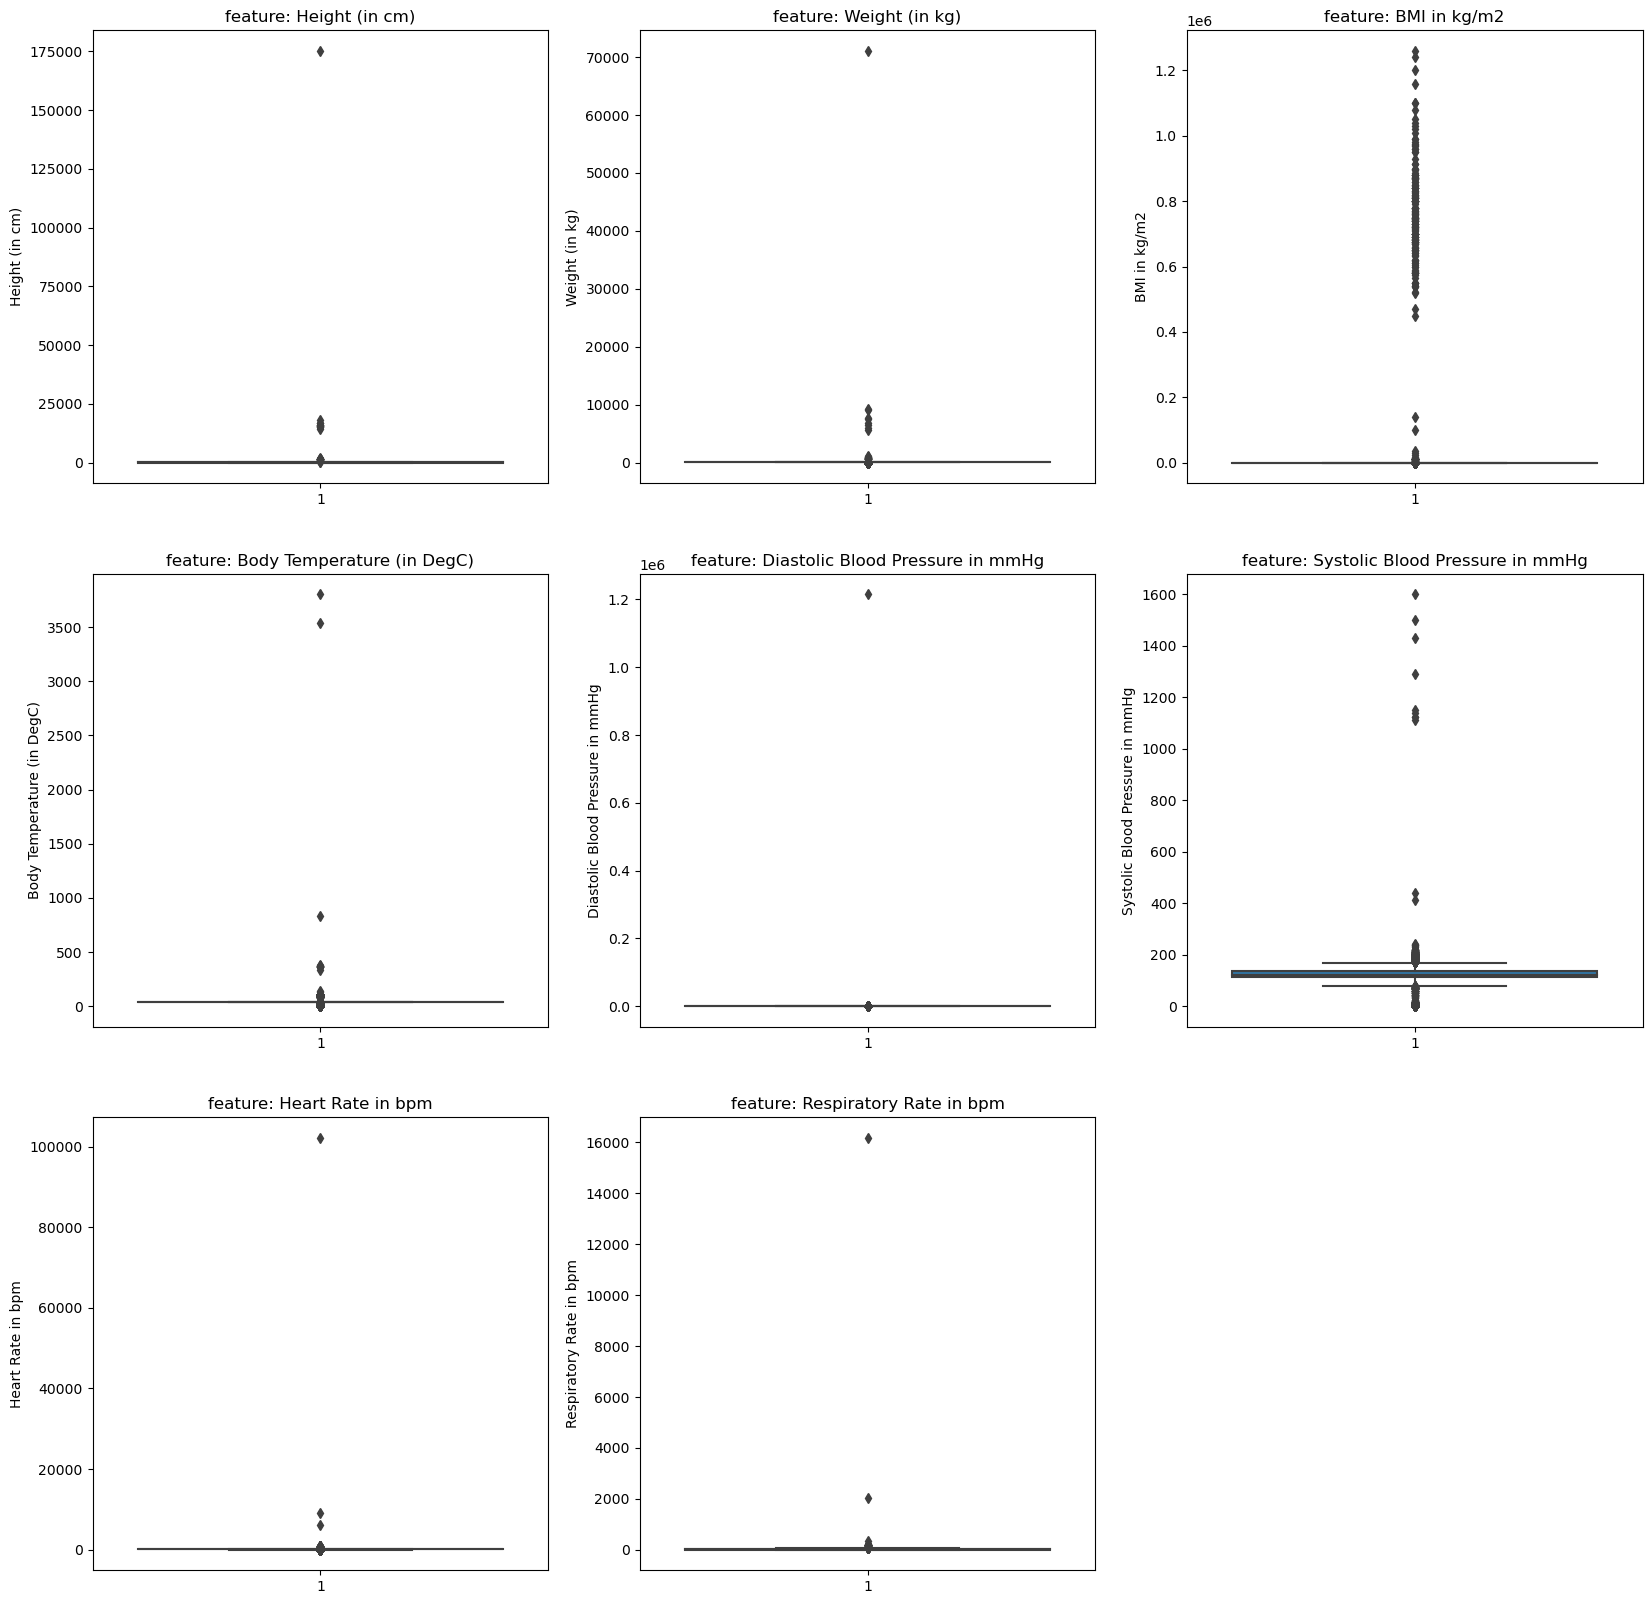

In [98]:
plot_box(diabetes_df, obs_col)

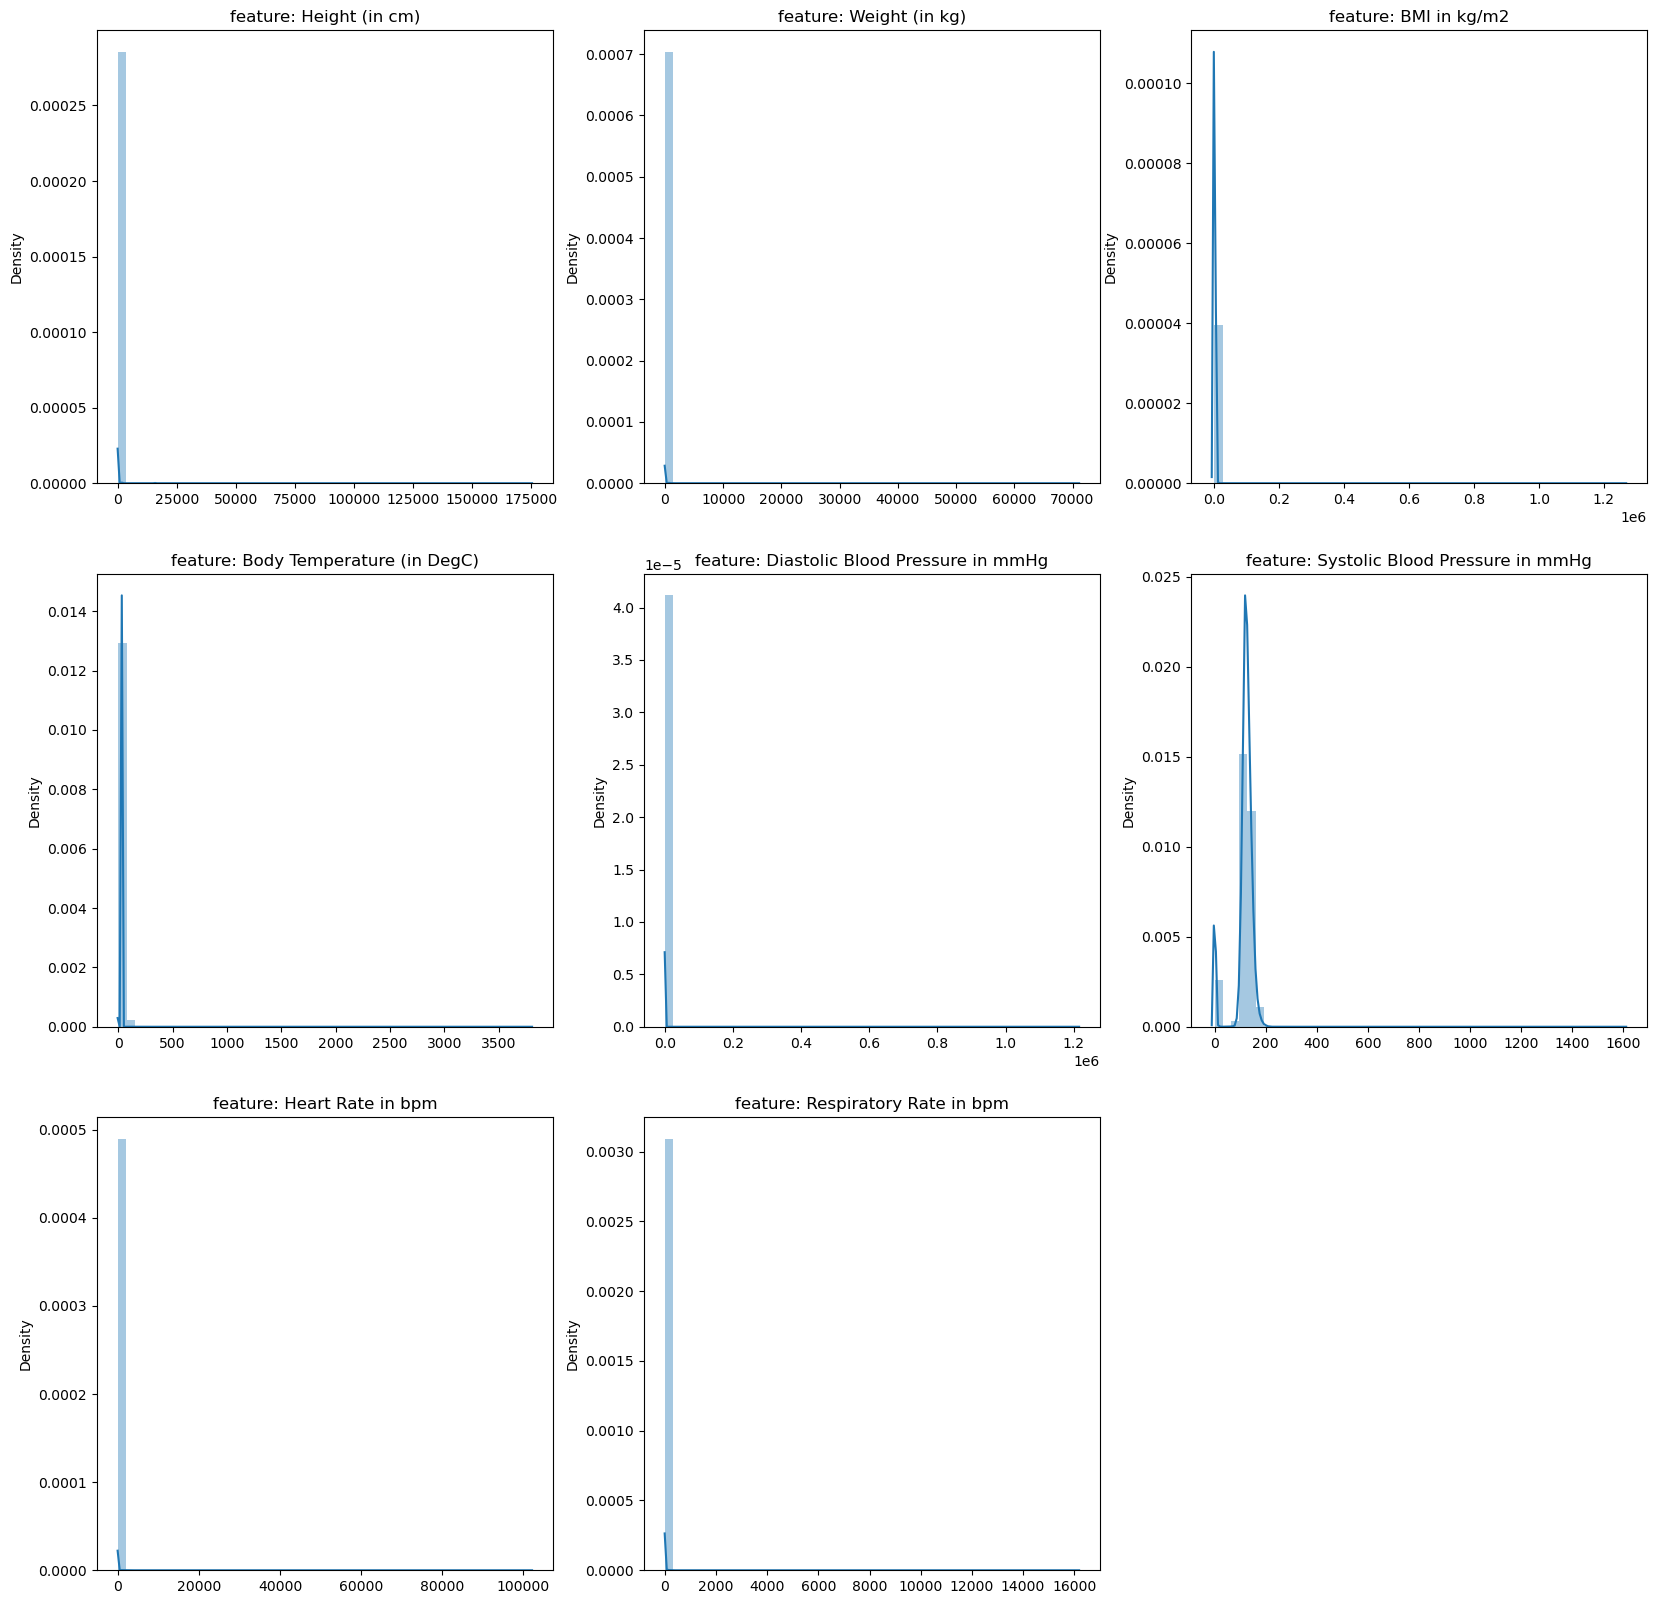

In [89]:
plot_dist(diabetes_df, obs_col)

## IMPORT THE DATA HERE

In [95]:
#I will export the cuurent df to resume the work from here, as the environment variables will be lost if the kernel is restarted
diabetes_df.to_csv('final_diabetes_df.csv', index = False)

In [101]:
current_df = pd.read_csv('final_diabetes_df.csv')

In [109]:
#Fill the 0 values in the columns with the mean of the column
def fill_zero(data, col):
  for i in col:
    data[i].replace(0, data[i].mean(), inplace = True)

#we will fill the 0 values in the columns with the mean of the column, because the 0 values are not possible in the columns
#we cannot fill the 0 values with the median, because the median is 0 in the columns

In [107]:
fill_zero(current_df, obs_col)

In [108]:
current_df.head()

Patient Diagnosis_Code                              Diagnosis_Description   
0    59268          E07.9                   Disorder of thyroid, unspecified  \
1    67031          R14.3                                         Flatulence   
2    68424          J05.0               Acute obstructive laryngitis (croup)   
3    77992         R79.89  Other specified abnormal findings of blood che...   
4    82896         K29.00                   Acute gastritis without bleeding   

  ResultInterpretation ResultValue  ResultValueUnits TestItemCode_Description   
0               Normal  28/08/2022             mg/dl                     DATE  \
1               Normal      <0.100  mIU/ml\X0D\\X0A\        BETA H C G LEVELS   
2               Normal         2.5              mg/L       C Reactive Protein   
3               Normal         6.3                 %                   HbA1C.   
4               Normal        19.4               U/L               SGPT / ALT   

   Age               Citizen  Gender  Target  Height (in cm)  Weight (in kg)   
0   41  UNITED ARAB EMIRATES  Female       1             154              72  \
1   38  UNITED ARAB EMIRATES  Female       1             158              78   
2    3  UNITED ARAB EMIRATES    Male       1           123.6            16.3   
3   70               Emirati  Female       1             152              76   
4   40  UNITED ARAB EMIRATES    Male       1           123.6              85   

   BMI in kg/m2  Body Temperature (in DegC)  Diastolic Blood Pressure in mmHg   
0         1,108                        37.2                                54  \
1         1,108                        36.5                                79   
2         1,108                        37.2                             80.07   
3         32.89                        37.1                               106   
4         1,108                        36.8                                82   

   Systolic Blood Pressure in mmHg  Heart Rate in bpm  Respiratory Rate in bpm  
0                               96                 77                       18  
1                              115                 76                       20  
2                            116.6                130                       20  
3                              218              71.82                    13.68  
4                              132                 72                       20

In [116]:
#we will filter values where height and weight are 1
handw_df = current_df[(current_df['Height (in cm)'] == 1) & (current_df['Weight (in kg)'] == 1)]
handw_df['Patient'].nunique()

94

In [114]:
handw_df.value_counts()

Patient  Diagnosis_Code  Diagnosis_Description                                 ResultInterpretation  ResultValue  ResultValueUnits  TestItemCode_Description                Age  Citizen    Gender  Target  Height (in cm)  Weight (in kg)  BMI in kg/m2  Body Temperature (in DegC)  Diastolic Blood Pressure in mmHg  Systolic Blood Pressure in mmHg  Heart Rate in bpm  Respiratory Rate in bpm
193908   L81.4           Other melanin hyperpigmentation                       Normal                4.36         mIU/L             TSH                                     47   Indian     Female  1       1               1               1e+04         36.5                        80                                120                              71.82              13.68                      1
2709650  J02.8           Acute pharyngitis due to other specified organisms    Normal                40.5         mg/L              CRP                                     33   Jordanian  Female  1       1              

In [117]:
diabetes_df.shape

(121211, 19)

# Non Diabetic Patients

Data Loading and Initial Pre Processing

In [102]:
entire_df_non = pd.read_csv('NonDiabetic.csv')

In [103]:
non_diabetic_df = entire_df_non.copy()

In [104]:
stats(non_diabetic_df)

The shape of the data is:  (5957566, 14)
The number of rows is:  5957566
The number of columns is:  14
The data types are:  Patient                                        int64
Diagnosis_Code                                object
DiagnosisGroup                                object
Diagnosis_Description                         object
ResultInterpretation                          object
ResultValue                                   object
ResultValueUnits                              object
TestItemCode_Description                      object
ObservationValue                              object
ObservationCode_Description                   object
ObservationCode_ObservationValueUnits_Code    object
Age                                            int64
Gender_Name                                   object
Citizenship_Description                       object
dtype: object
The null values are:  Patient                                             0
Diagnosis_Code                              

In [107]:
non_diabetic_df.head()

Patient Diagnosis_Code DiagnosisGroup      Diagnosis_Description   
0   171439          U07.1            U07  COVID 19 virus identified  \
1   171439          U07.1            U07  COVID 19 virus identified   
2   171439          U07.1            U07  COVID 19 virus identified   
3   171439          U07.1            U07  COVID 19 virus identified   
4   171439          U07.1            U07  COVID 19 virus identified   

  ResultInterpretation   ResultValue ResultValueUnits   
0               Normal  Not Detected              NaN  \
1               Normal  Not Detected              NaN   
2               Normal  Not Detected              NaN   
3               Normal  Not Detected              NaN   
4               Normal  Not Detected              NaN   

  TestItemCode_Description ObservationValue ObservationCode_Description   
0             COVID-19 PCR               20            Respiratory Rate  \
1             COVID-19 PCR              118     Systolic Blood Pressure   
2             COVID-19 PCR               66    Diastolic Blood Pressure   
3             COVID-19 PCR               56                      Weight   
4             COVID-19 PCR              142                      Height   

  ObservationCode_ObservationValueUnits_Code  Age Gender_Name   
0                                        bpm   48      Female  \
1                                       mmHg   48      Female   
2                                       mmHg   48      Female   
3                                         kg   48      Female   
4                                         cm   48      Female   

  Citizenship_Description  Target  
0                 EMIRATI       0  
1                 EMIRATI       0  
2                 EMIRATI       0  
3                 EMIRATI       0  
4                 EMIRATI       0

In [106]:
non_diabetic_df['Target'] = 0

In [108]:
non_diabetic_df = non_diabetic_df.groupby('Patient').last().reset_index()

In [109]:
#check the number of distinct patients in the new df
print("The number of distinct patients in the new df are: ", non_diabetic_df['Patient'].nunique())

The number of distinct patients in the new df are:  180739


In [111]:
non_diabetic_df.shape

(180739, 15)

In [118]:
for col in non_diabetic_df.columns:
    print(col)

Patient
Diagnosis_Code
DiagnosisGroup
Diagnosis_Description
ResultInterpretation
ResultValue
ResultValueUnits
TestItemCode_Description
ObservationValue
ObservationCode_Description
ObservationCode_ObservationValueUnits_Code
Age
Gender
Citizen
Target


In [117]:
#Rename the columns

non_diabetic_df.rename(columns= {'Citizenship_Description': 'Citizen', 'Gender_Name': 'Gender'}, inplace = True)


# Now we will merge the Diabetic and Non Diabetic initially normalized and pre processed datasets, to further handle the Missing values and NaN's

In [124]:
non_diabetic_df = pd.read_csv('FinalNonDiabetic.csv')

In [125]:
non_diabetic_df.shape

(180739, 19)

In [126]:
#Merge the two csv's to get the final df
final_df = pd.concat([non_diabetic_df, diabetes_df], axis = 0)

#axis 0 means row wise concatenation, meaning the rows will be added


In [127]:
final_df.shape

(301950, 19)

In [128]:
#randomly shuffle the df
final_df = final_df.sample(frac = 1).reset_index(drop = True)

#here frac = 1 means 100% of the rows will be returned in the random sample, and drop = True means the original index will be removed from the df

In [129]:
final_df.shape

(301950, 19)

In [130]:
final_df.head()

Patient Diagnosis_Code                              Diagnosis_Description   
0   192699          D50.9                Iron deficiency anemia, unspecified  \
1   166710          E78.5                        Hyperlipidemia, unspecified   
2  2644517          R11.2                  Nausea with vomiting, unspecified   
3  1079401          N91.1                               Secondary amenorrhea   
4   317560            Z09  Encounter for follow-up examination after comp...   

  ResultInterpretation   ResultValue ResultValueUnits   
0               Normal  Not Detected              NaN  \
1               Normal          67.7               ZZ   
2               Normal            87            mg/dL   
3                  NaN         0.100             IU/L   
4               Normal          NEG.              NaN   

      TestItemCode_Description  Age  Gender  Citizen  Target Height (in cm)   
0                 COVID-19 PCR   25  Female  EMIRATI       0            156  \
1                         eGFR   57  Female  EMIRATI       0            NaN   
2  Glucose, Fasting-FBS, Blood   31  Female  Emirati       1          163.6   
3        BETA HCG Quantitative   44  Female  Unknown       0            161   
4               Influenza B Ab    8    Male  EMIRATI       0            135   

  Weight (in kg)  BMI in kg/m2 Body Temperature (in DegC)   
0            108            44                       36.3  \
1            NaN           NaN                         37   
2          102.9         38.45                       36.8   
3             63            24                       36.7   
4            NaN           NaN                        NaN   

  Diastolic Blood Pressure in mmHg Systolic Blood Pressure in mmHg   
0                               81                             119  \
1                               77                             111   
2                               80                             119   
3                               70                             105   
4                              NaN                             NaN   

  Heart Rate in bpm  Respiratory Rate in bpm  
0                82                       20  
1                88                       18  
2                76                       16  
3                87                       22  
4                89                      NaN

In [133]:
#plot the distribution of the target variable
fig = go.Figure(data=[go.Pie(labels=final_df['Target'].value_counts().index, values=final_df['Target'].value_counts().values, hole=.3)])
fig.show()

In [134]:
#Export the final df to csv
# final_df.to_csv('Trainingdata.csv', index = False)

# Commence the Training!

In [138]:
#Replace the NAN values with 0 in the numerical columns, because the conversion gives error if there are any NAN values
obs_col = ['Height (in cm)', 'Weight (in kg)', 'BMI in kg/m2', 'Body Temperature (in DegC)', 'Diastolic Blood Pressure in mmHg', 'Systolic Blood Pressure in mmHg', 'Heart Rate in bpm', 'Respiratory Rate in bpm']

In [140]:
#replace the 0 values with the 0
for i in obs_col:
    final_df[i].fillna(0, inplace = True)

In [141]:
final_df.head()

Patient Diagnosis_Code                              Diagnosis_Description   
0   192699          D50.9                Iron deficiency anemia, unspecified  \
1   166710          E78.5                        Hyperlipidemia, unspecified   
2  2644517          R11.2                  Nausea with vomiting, unspecified   
3  1079401          N91.1                               Secondary amenorrhea   
4   317560            Z09  Encounter for follow-up examination after comp...   

  ResultInterpretation   ResultValue ResultValueUnits   
0               Normal  Not Detected              NaN  \
1               Normal          67.7               ZZ   
2               Normal            87            mg/dL   
3                  NaN         0.100             IU/L   
4               Normal          NEG.              NaN   

      TestItemCode_Description  Age  Gender  Citizen  Target Height (in cm)   
0                 COVID-19 PCR   25  Female  EMIRATI       0            156  \
1                         eGFR   57  Female  EMIRATI       0              0   
2  Glucose, Fasting-FBS, Blood   31  Female  Emirati       1          163.6   
3        BETA HCG Quantitative   44  Female  Unknown       0            161   
4               Influenza B Ab    8    Male  EMIRATI       0            135   

  Weight (in kg)  BMI in kg/m2 Body Temperature (in DegC)   
0            108            44                       36.3  \
1              0             0                         37   
2          102.9         38.45                       36.8   
3             63            24                       36.7   
4              0             0                          0   

  Diastolic Blood Pressure in mmHg Systolic Blood Pressure in mmHg   
0                               81                             119  \
1                               77                             111   
2                               80                             119   
3                               70                             105   
4                                0                               0   

  Heart Rate in bpm  Respiratory Rate in bpm  
0                82                       20  
1                88                       18  
2                76                       16  
3                87                       22  
4                89                        0

In [150]:
#replace the 'ON WEELCHAIR' with 0
final_df['Height (in cm)'].replace('ON WEELCHAIR', 91.4, inplace = True)
final_df['Height (in cm)'].replace('wheelchair', 91.4, inplace = True)

#Here we have replaced the 'ON WEELCHAIR' with 91.4, because the average height of a person on a wheelchair is 91.4 cm

In [154]:
#remove the cm from the number in some entries from the hight column
final_df['Height (in cm)'] = final_df['Height (in cm)'].apply(lambda x: x.replace('cm', '') if isinstance(x, str) else x)

In [155]:
final_df['Height (in cm)'] = final_df['Height (in cm)'].astype(float)

In [157]:
final_df['Weight (in kg)'].replace('ON WEELCHAIR', fill_null_mean, inplace = True)
final_df['Weight (in kg)'].replace('wheelchair', fill_null_mean, inplace = True)

In [159]:
final_df.dtypes

Patient                               int64
Diagnosis_Code                       object
Diagnosis_Description                object
ResultInterpretation                 object
ResultValue                          object
ResultValueUnits                     object
TestItemCode_Description             object
Age                                 float64
Gender                               object
Citizen                              object
Target                                int64
Height (in cm)                      float64
Weight (in kg)                       object
BMI in kg/m2                        float64
Body Temperature (in DegC)           object
Diastolic Blood Pressure in mmHg     object
Systolic Blood Pressure in mmHg      object
Heart Rate in bpm                    object
Respiratory Rate in bpm             float64
dtype: object

In [161]:
print(final_df['Weight (in kg)'].dtype)


object


In [168]:
final_df['Weight (in kg)'] = pd.to_numeric(final_df['Weight (in kg)'], errors='coerce')
final_df['Body Temperature (in DegC)'] = pd.to_numeric(final_df['Body Temperature (in DegC)'], errors='coerce')
final_df['Diastolic Blood Pressure in mmHg'] = pd.to_numeric(final_df['Diastolic Blood Pressure in mmHg'], errors='coerce')
final_df['Systolic Blood Pressure in mmHg'] = pd.to_numeric(final_df['Systolic Blood Pressure in mmHg'], errors='coerce')
final_df['Heart Rate in bpm'] = pd.to_numeric(final_df['Heart Rate in bpm'], errors='coerce')
final_df['Respiratory Rate in bpm'] = pd.to_numeric(final_df['Respiratory Rate in bpm'], errors='coerce')


In [169]:
#Convert the columns to float
final_df['Weight (in kg)'] = final_df['Weight (in kg)'].astype(float)
final_df['BMI in kg/m2'] = final_df['BMI in kg/m2'].astype(float)
final_df['Body Temperature (in DegC)'] = final_df['Body Temperature (in DegC)'].astype(float)
final_df['Diastolic Blood Pressure in mmHg'] = final_df['Diastolic Blood Pressure in mmHg'].astype(float)
final_df['Systolic Blood Pressure in mmHg'] = final_df['Systolic Blood Pressure in mmHg'].astype(float)
final_df['Heart Rate in bpm'] = final_df['Heart Rate in bpm'].astype(float)
final_df['Respiratory Rate in bpm'] = final_df['Respiratory Rate in bpm'].astype(float)

In [170]:
final_df.dtypes

Patient                               int64
Diagnosis_Code                       object
Diagnosis_Description                object
ResultInterpretation                 object
ResultValue                          object
ResultValueUnits                     object
TestItemCode_Description             object
Age                                 float64
Gender                               object
Citizen                              object
Target                                int64
Height (in cm)                      float64
Weight (in kg)                      float64
BMI in kg/m2                        float64
Body Temperature (in DegC)          float64
Diastolic Blood Pressure in mmHg    float64
Systolic Blood Pressure in mmHg     float64
Heart Rate in bpm                   float64
Respiratory Rate in bpm             float64
dtype: object

In [171]:
#Now after the columns are converted to float, we will calculate the BMI
final_df['Calc-BMI'] = final_df['Weight (in kg)'] / final_df['Height (in cm)'] / final_df['Height (in cm)'] * 10000

In [172]:
final_df.head()

Patient Diagnosis_Code                              Diagnosis_Description   
0   192699          D50.9                Iron deficiency anemia, unspecified  \
1   166710          E78.5                        Hyperlipidemia, unspecified   
2  2644517          R11.2                  Nausea with vomiting, unspecified   
3  1079401          N91.1                               Secondary amenorrhea   
4   317560            Z09  Encounter for follow-up examination after comp...   

  ResultInterpretation   ResultValue ResultValueUnits   
0               Normal  Not Detected              NaN  \
1               Normal          67.7               ZZ   
2               Normal            87            mg/dL   
3                  NaN         0.100             IU/L   
4               Normal          NEG.              NaN   

      TestItemCode_Description  Age  Gender  Citizen  Target  Height (in cm)   
0                 COVID-19 PCR   25  Female  EMIRATI       0             156  \
1                         eGFR   57  Female  EMIRATI       0               0   
2  Glucose, Fasting-FBS, Blood   31  Female  Emirati       1           163.6   
3        BETA HCG Quantitative   44  Female  Unknown       0             161   
4               Influenza B Ab    8    Male  EMIRATI       0             135   

   Weight (in kg)  BMI in kg/m2  Body Temperature (in DegC)   
0             108            44                        36.3  \
1               0             0                          37   
2           102.9         38.45                        36.8   
3              63            24                        36.7   
4               0             0                           0   

   Diastolic Blood Pressure in mmHg  Systolic Blood Pressure in mmHg   
0                                81                              119  \
1                                77                              111   
2                                80                              119   
3                                70                              105   
4                                 0                                0   

   Heart Rate in bpm  Respiratory Rate in bpm  Calc-BMI  
0                 82                       20     44.38  
1                 88                       18       NaN  
2                 76                       16     38.45  
3                 87                       22      24.3  
4                 89                        0         0

In [178]:
null_columns(final_df).sort_values(by = "Null Values", ascending = False)

Null Values  % Null Values
ResultValueUnits                       115832          38.36
BMI in kg/m2                            45173          14.96
ResultInterpretation                    35054          11.61
Systolic Blood Pressure in mmHg           199           0.07
Diastolic Blood Pressure in mmHg          135           0.04
Heart Rate in bpm                          63           0.02
Body Temperature (in DegC)                 10              0
Weight (in kg)                              7              0
ResultValue                                 1              0
Age                                         1              0
Gender                                      1              0
Citizen                                     1              0

In [174]:
#Copy the Calc-BMI column to the BMI in kg/m2 column
final_df['BMI in kg/m2'] = final_df['Calc-BMI']


In [177]:
final_df.head()

Patient Diagnosis_Code                              Diagnosis_Description   
0   192699          D50.9                Iron deficiency anemia, unspecified  \
1   166710          E78.5                        Hyperlipidemia, unspecified   
2  2644517          R11.2                  Nausea with vomiting, unspecified   
3  1079401          N91.1                               Secondary amenorrhea   
4   317560            Z09  Encounter for follow-up examination after comp...   

  ResultInterpretation   ResultValue ResultValueUnits   
0               Normal  Not Detected              NaN  \
1               Normal          67.7               ZZ   
2               Normal            87            mg/dL   
3                  NaN         0.100             IU/L   
4               Normal          NEG.              NaN   

      TestItemCode_Description  Age  Gender  Citizen  Target  Height (in cm)   
0                 COVID-19 PCR   25  Female  EMIRATI       0             156  \
1                         eGFR   57  Female  EMIRATI       0               0   
2  Glucose, Fasting-FBS, Blood   31  Female  Emirati       1           163.6   
3        BETA HCG Quantitative   44  Female  Unknown       0             161   
4               Influenza B Ab    8    Male  EMIRATI       0             135   

   Weight (in kg)  BMI in kg/m2  Body Temperature (in DegC)   
0             108         44.38                        36.3  \
1               0           NaN                          37   
2           102.9         38.45                        36.8   
3              63          24.3                        36.7   
4               0             0                           0   

   Diastolic Blood Pressure in mmHg  Systolic Blood Pressure in mmHg   
0                                81                              119  \
1                                77                              111   
2                                80                              119   
3                                70                              105   
4                                 0                                0   

   Heart Rate in bpm  Respiratory Rate in bpm  
0                 82                       20  
1                 88                       18  
2                 76                       16  
3                 87                       22  
4                 89                        0

In [176]:
#Drop the Calc-BMI column
final_df.drop('Calc-BMI', axis = 1, inplace = True)


# We will now pre process the TestItemCode description

In [180]:
testitem = pd.read_csv('TestItemCode_Description.csv')

In [181]:
testitem.groupby('Standardized Name')['TestItemCodeDescription'].nunique()

Standardized Name
ALB         8
ALP        12
ALT        17
AMY        11
AST        16
CAL        16
CK          9
CORT        9
CRP        21
CRPhs       2
CRTN       15
DBIL       11
DHEAS       4
ESR        13
FBS        23
FINS        8
FIS         1
FSH         6
FT3        14
FT4        12
GRBS        7
HDL        17
HbA1c      20
IBIL        3
INS         5
INSPP       6
KTN         8
LDL        21
MGSM        7
POTSM      13
PPBS       41
PRTN        1
RBS        26
RUC         3
TBIL       18
TCHOL      22
TORPIhs     3
TRIG       15
TROPI      11
TROPIhs     1
TROPT       5
TROPThs     4
TSH        13
UGC         4
UKA         3
UREA       14
URIC        1
VITD       23
VLDL        8
ZINC        8
Name: TestItemCodeDescription, dtype: int64

In [227]:
#We will group the TestItemCode_Description column by the Standardized Name column 

#We will create a dictionary with the Standardized Name as the key and the TestItemCode_Description as the value
testitemdict = dict(zip(testitem['Standardized Name'], testitem['TestItemCodeDescription']))



In [228]:
testitemdict

{nan: 'Zinc Lvl',
 'ALB': 'Albumin-Serum',
 'ALP': 'Phosphatase, alkaline',
 'ALT': 'Transferase; alanine amino (ALT) (SGPT)',
 'AMY': 'Total Amylase',
 'CAL': 'Ionized Calcium',
 'CRP': 'CRP, C-reactive protein, Serum',
 'CRTN': 'Serum ,Creatinine',
 'DBIL': 'Direct Bilirubin-Serum',
 'ESR': 'Sedimentation rate, erythrocyte; automated',
 'FBS': 'GTT-FBS',
 'FSH': 'Gonadotropin; follicle stimulating hormone (FSH) , Serum*',
 'FT3': 'Triiodothyronine Total (T3),Serum',
 'FT4': 'Total T4',
 'PPBS': 'PPBS',
 'HDL': 'Lipoprotein, direct measurement; high density cholesterol (HDL cholesterol)',
 'HbA1c': 'Hgb A1c',
 'LDL': 'LOW-DENSITY LIPOPROTEIN',
 'MGSM': 'MAGNESIUM.',
 'POTSM': 'Serum Potassium',
 'RBS': 'RBS (Random Blood Sugar)',
 'TBIL': 'Total Bilirubin-Serum',
 'TCHOL': 'Total Cholestrol',
 'TRIG': 'Triglycerides-Serum',
 'TROPI': 'TROPONIN, SERUM (QUALITATIVE)',
 'UREA': 'Urea, Serum',
 'URIC': '* URIC ACID',
 'VITD': 'Vitamin D3 (25 Hydroxy-Cholechalciferol)',
 'CORT': 'Serum Cor

In [229]:
testitem.groupby('Standardized Name')['TestItemCodeDescription'].unique()

Standardized Name
ALB        [* ALBUMIN, * Albumin, ALBUMIN, Albumin, Album...
ALP        [* ALKALINE PHOSPHATASE, Alk Phos, ALKALINE PH...
ALT        [* ALT (SGPT), Alanine Aminotransferase (ALT),...
AMY        [* AMYLASE, AMYLASE, Amylase, Amylase , Serum,...
AST        [Asparate Aminotransferase SGOT, Aspartate Ami...
CAL        [* CALCIUM, CALCIUM, Calcium, Calcium Ionized,...
CK         [CK - MB, Serum, CK MB, Creatine Kinase, Creat...
CORT       [.Cortisol 180 min, Cortisol - AM*, Cortisol 8...
CRP        [* C-REACTIVE PROTEIN, C Reactive Potein, C Re...
CRPhs      [C-reactive protein - High Sensitivity*, C-REA...
CRTN       [* CREATININE, * Creatinine, Creatinine, CREAT...
DBIL       [* DIRECT BILIRUBIN, Bili Direct, BILIRUBIN DI...
DHEAS      [Dehydroepiandrosterone Sulphate, DHEAS, Serum...
ESR        [* ERYTHROCYTE SEDIMENTATION RATE (ESR), BLOOD...
FBS        [* FASTING BLOOD SUGAR, * GLUCOSE (FASTING), B...
FINS       [INSULIN  FASTING, Insulin (Fasting), Insulin ...
FIS   

In [230]:
#Display the df after the groupby
testitem.groupby('Standardized Name')['TestItemCodeDescription'].unique().reset_index()


Standardized Name                            TestItemCodeDescription
0                ALB  [* ALBUMIN, * Albumin, ALBUMIN, Albumin, Album...
1                ALP  [* ALKALINE PHOSPHATASE, Alk Phos, ALKALINE PH...
2                ALT  [* ALT (SGPT), Alanine Aminotransferase (ALT),...
3                AMY  [* AMYLASE, AMYLASE, Amylase, Amylase , Serum,...
4                AST  [Asparate Aminotransferase SGOT, Aspartate Ami...
5                CAL  [* CALCIUM, CALCIUM, Calcium, Calcium Ionized,...
6                 CK  [CK - MB, Serum, CK MB, Creatine Kinase, Creat...
7               CORT  [.Cortisol 180 min, Cortisol - AM*, Cortisol 8...
8                CRP  [* C-REACTIVE PROTEIN, C Reactive Potein, C Re...
9              CRPhs  [C-reactive protein - High Sensitivity*, C-REA...
10              CRTN  [* CREATININE, * Creatinine, Creatinine, CREAT...
11              DBIL  [* DIRECT BILIRUBIN, Bili Direct, BILIRUBIN DI...
12             DHEAS  [Dehydroepiandrosterone Sulphate, DHEAS, Serum...
13               ESR  [* ERYTHROCYTE SEDIMENTATION RATE (ESR), BLOOD...
14               FBS  [* FASTING BLOOD SUGAR, * GLUCOSE (FASTING), B...
15              FINS  [INSULIN  FASTING, Insulin (Fasting), Insulin ...
16               FIS                                  [FASTING INSULIN]
17               FSH  [* FSH ( Follicle Stimulating Hormone ), Folli...
18               FT3  [* FT3 ( Free Triiodothyronine ), FREE T3, FRE...
19               FT4  [* FT4 ( Free Thyroxine ), FREE T4, FT4 ( Thyr...
20              GRBS  [Blood Glucose POC, Glucose Art POC, GLUCOSE G...
21               HDL  [* HDL CHOLESTEROL, CHOLESTEROL HDL, Cholester...
22             HbA1c  [* HEMOGLOBIN GLYCOSYLATED A1C, Glycosylated H...
23              IBIL  [Bilirubin, Indirect, INDIRECT BILIRUBIN, Indi...
24               INS  [Insulin, Insulin Baseline, Insulin- Random, S...
25             INSPP  [Insulin  1 hour post 75 gm Glucose, Insulin 2...
26               KTN  [Blood Ketone POC, KETONE, Ketone, Ketone bodi...
27               LDL  [* LDL  Choelsterol  Direct, CHOLESTEROL LDL(D...
28              MGSM  [* MAGNESIUM, MAGNESIUM, Magnesium, Magnesium ...
29             POTSM  [* POTASSIUM, * Potassium, POTASSIUM, POTASSIU...
30              PPBS  [* GLUCOSE (1sT Hr), 1 HOUR GLUCOSE, 2 HOURS G...
31              PRTN                                    [Total Protein]
32               RBS  [* RANDOM BLOOD GLUCOSE, Blood sugar - Random,...
33               RUC  [Creatinine Urine (Random), Creatinine, Random...
34              TBIL  [* TOTAL BILIRUBIN, Bili Total, Bilirubin, BIL...
35             TCHOL  [* TOTAL CHOLESTEROL, * Total Cholesterol, Cho...
36           TORPIhs  [hs-TROPONIN - I (POCT), hs-TROPONIN I, Tropon...
37              TRIG  [* TRIGLYCERIDES, Serum Triglyceride, Serum Tr...
38             TROPI  [* Troponin I (Quantitative), TROPININ I QUANT...
39           TROPIhs                        [Troponin I high sensetive]
40             TROPT  [Troponin  T, Troponin T, Troponin T (POCT), T...
41           TROPThs  [Troponin -T (HS), TROPONIN T HIGH SENSITIVE, ...
42               TSH  [THYROID STIMULATING HORMONE, Thyroid Stimulat...
43               UGC  [U Glucose, UA Glucose, UA-Glucose, Urine anal...
44               UKA            [UA Ketones, UA-Ketones, Urine ketones]
45              UREA  [* Urea, * UREA, BLOOD  UREA, Blood Urea, BLOO...
46              URIC                                      [* URIC ACID]
47              VITD  [* VITAMIN D (25 Hydroxy Vitamin D), 25 - OH -...
48              VLDL  [VLDL, VLDL Cholesterol, VLDL CHOLESTEROL, VLD...
49              ZINC  [METAL ZINC, WHOLE BLOOD, Zinc in Serum, Zinc*...

In [231]:
#Now we will create a dictionary with the Standardized Name as the key and the TestItemCode_Description as the value
testitemdict = dict(zip(testitem['Standardized Name'], testitem['TestItemCodeDescription']))

In [235]:
#Now we will map this dictionary to the TestItemCode_Description column in the final_df
final_df['TestItemCode_Description'] = final_df['TestItemCode_Description'].map(testitemdict)

In [236]:
final_df.head()

Patient Diagnosis_Code                              Diagnosis_Description   
0   192699          D50.9                Iron deficiency anemia, unspecified  \
1   166710          E78.5                        Hyperlipidemia, unspecified   
2  2644517          R11.2                  Nausea with vomiting, unspecified   
3  1079401          N91.1                               Secondary amenorrhea   
4   317560            Z09  Encounter for follow-up examination after comp...   

  ResultInterpretation   ResultValue ResultValueUnits   
0               Normal  Not Detected              NaN  \
1               Normal          67.7               ZZ   
2               Normal            87            mg/dL   
3                  NaN         0.100             IU/L   
4               Normal          NEG.              NaN   

  TestItemCode_Description  Age  Gender  Citizen  Target  Height (in cm)   
0                 Zinc Lvl   25  Female  EMIRATI       0             156  \
1                 Zinc Lvl   57  Female  EMIRATI       0               0   
2                  GTT-FBS   31  Female  Emirati       1           163.6   
3                 Zinc Lvl   44  Female  Unknown       0             161   
4                 Zinc Lvl    8    Male  EMIRATI       0             135   

   Weight (in kg)  BMI in kg/m2  Body Temperature (in DegC)   
0             108         44.38                        36.3  \
1               0           NaN                          37   
2           102.9         38.45                        36.8   
3              63          24.3                        36.7   
4               0             0                           0   

   Diastolic Blood Pressure in mmHg  Systolic Blood Pressure in mmHg   
0                                81                              119  \
1                                77                              111   
2                                80                              119   
3                                70                              105   
4                                 0                                0   

   Heart Rate in bpm  Respiratory Rate in bpm  
0                 82                       20  
1                 88                       18  
2                 76                       16  
3                 87                       22  
4                 89                        0

In [238]:
final_df['TestItemCode_Description'].value_counts()

TestItemCode_Description
Zinc Lvl                                                                       207773
Hgb A1c                                                                         30571
CRP, C-reactive protein, Serum                                                  10299
Vitamin D3 (25 Hydroxy-Cholechalciferol)                                         7009
TSH-THYROID STIMULATING HORMONE                                                  5388
RBS (Random Blood Sugar)                                                         5051
Serum ,Creatinine                                                                3671
Transferase; alanine amino (ALT) (SGPT)                                          2875
Total T4                                                                         2476
GTT-FBS                                                                          2017
Triglycerides-Serum                                                              1738
Sedimentation rate, erythrocy

In [239]:
#Now convert the TestItemCode_Description distinct values to columns
final_df = one_hot(final_df, ['TestItemCode_Description'])


In [240]:
final_df.head()

Patient Diagnosis_Code                              Diagnosis_Description   
0   192699          D50.9                Iron deficiency anemia, unspecified  \
1   166710          E78.5                        Hyperlipidemia, unspecified   
2  2644517          R11.2                  Nausea with vomiting, unspecified   
3  1079401          N91.1                               Secondary amenorrhea   
4   317560            Z09  Encounter for follow-up examination after comp...   

  ResultInterpretation   ResultValue ResultValueUnits  Age  Gender  Citizen   
0               Normal  Not Detected              NaN   25  Female  EMIRATI  \
1               Normal          67.7               ZZ   57  Female  EMIRATI   
2               Normal            87            mg/dL   31  Female  Emirati   
3                  NaN         0.100             IU/L   44  Female  Unknown   
4               Normal          NEG.              NaN    8    Male  EMIRATI   

   Target  ...  TestItemCode_Description_Troponin I high sensetive   
0       0  ...                                              False   \
1       0  ...                                              False    
2       1  ...                                              False    
3       0  ...                                              False    
4       0  ...                                              False    

   TestItemCode_Description_Troponin I, High sensitive, Quantitative, Serum\ES   
0                                              False                            \
1                                              False                             
2                                              False                             
3                                              False                             
4                                              False                             

   TestItemCode_Description_Troponin T-High-Sensitivity   
0                                              False     \
1                                              False      
2                                              False      
3                                              False      
4                                              False      

   TestItemCode_Description_Urea, Serum   
0                                 False  \
1                                 False   
2                                 False   
3                                 False   
4                                 False   

   TestItemCode_Description_Urine analysis, glucose   
0                                             False  \
1                                             False   
2                                             False   
3                                             False   
4                                             False   

   TestItemCode_Description_Urine ketones   
0                                   False  \
1                                   False   
2                                   False   
3                                   False   
4                                   False   

   TestItemCode_Description_VLDL-Cholestrerol   
0                                       False  \
1                                       False   
2                                       False   
3                                       False   
4                                       False   

   TestItemCode_Description_Vitamin D3 (25 Hydroxy-Cholechalciferol)   
0                                              False                  \
1                                              False                   
2                                              False                   
3                                              False                   
4                                              False                   

   TestItemCode_Description_ZINC.  TestItemCode_Description_Zinc Lvl  
0                           False                               True  
1                           False              

In [241]:
for col in final_df.columns:
    print(col)

Patient
Diagnosis_Code
Diagnosis_Description
ResultInterpretation
ResultValue
ResultValueUnits
Age
Gender
Citizen
Target
Height (in cm)
Weight (in kg)
BMI in kg/m2
Body Temperature (in DegC)
Diastolic Blood Pressure in mmHg
Systolic Blood Pressure in mmHg
Heart Rate in bpm
Respiratory Rate in bpm
TestItemCode_Description_Albumin-Serum
TestItemCode_Description_C-REACTIVE PROTEIN, hS
TestItemCode_Description_CRP, C-reactive protein, Serum
TestItemCode_Description_Creatine Phosphokinase(CPK), Serum
TestItemCode_Description_Creatinine-Random Urine
TestItemCode_Description_DHEA-S, SERUM
TestItemCode_Description_Direct Bilirubin-Serum
TestItemCode_Description_FASTING INSULIN
TestItemCode_Description_GRBS - GLUCOSE BLOOD REAGENT STRIP
TestItemCode_Description_GTT-FBS
TestItemCode_Description_Gonadotropin; follicle stimulating hormone (FSH) , Serum*
TestItemCode_Description_Hgb A1c
TestItemCode_Description_INSULIN, POST PRANDIAL
TestItemCode_Description_Indirect Bilirubin-Serum
TestItemCode_De

In [244]:
#filter the columns with the word 'TestItemCode_Description'
testitem_col = [col for col in final_df.columns if 'TestItemCode_Description' in col]
testitem_col

['TestItemCode_Description_Albumin-Serum',
 'TestItemCode_Description_C-REACTIVE PROTEIN, hS',
 'TestItemCode_Description_CRP, C-reactive protein, Serum',
 'TestItemCode_Description_Creatine Phosphokinase(CPK), Serum',
 'TestItemCode_Description_Creatinine-Random Urine',
 'TestItemCode_Description_DHEA-S, SERUM',
 'TestItemCode_Description_Direct Bilirubin-Serum',
 'TestItemCode_Description_FASTING INSULIN',
 'TestItemCode_Description_GRBS - GLUCOSE BLOOD REAGENT STRIP',
 'TestItemCode_Description_GTT-FBS',
 'TestItemCode_Description_Gonadotropin; follicle stimulating hormone (FSH) , Serum*',
 'TestItemCode_Description_Hgb A1c',
 'TestItemCode_Description_INSULIN, POST PRANDIAL',
 'TestItemCode_Description_Indirect Bilirubin-Serum',
 'TestItemCode_Description_Insulin,Fasting',
 'TestItemCode_Description_Insulin; total*',
 'TestItemCode_Description_Ionized Calcium',
 'TestItemCode_Description_KETONES.',
 'TestItemCode_Description_LOW-DENSITY LIPOPROTEIN',
 'TestItemCode_Description_Lipo

In [246]:
#sort the testitem_col in descending order of the number of False count
final_df[testitem_col].sum().sort_values(ascending=False)

TestItemCode_Description_Zinc Lvl                                                                       207773
TestItemCode_Description_Hgb A1c                                                                         30571
TestItemCode_Description_CRP, C-reactive protein, Serum                                                  10299
TestItemCode_Description_Vitamin D3 (25 Hydroxy-Cholechalciferol)                                         7009
TestItemCode_Description_TSH-THYROID STIMULATING HORMONE                                                  5388
TestItemCode_Description_RBS (Random Blood Sugar)                                                         5051
TestItemCode_Description_Serum ,Creatinine                                                                3671
TestItemCode_Description_Transferase; alanine amino (ALT) (SGPT)                                          2875
TestItemCode_Description_Total T4                                                                         2476
T

In [251]:
#Convert the columns to float
testitem_col = [col for col in final_df.columns if 'TestItemCode_Description' in col]
final_df[testitem_col] = final_df[testitem_col].astype(float)


In [253]:
final_df.head()

Patient Diagnosis_Code                              Diagnosis_Description   
0   192699          D50.9                Iron deficiency anemia, unspecified  \
1   166710          E78.5                        Hyperlipidemia, unspecified   
2  2644517          R11.2                  Nausea with vomiting, unspecified   
3  1079401          N91.1                               Secondary amenorrhea   
4   317560            Z09  Encounter for follow-up examination after comp...   

  ResultInterpretation   ResultValue ResultValueUnits  Age  Gender  Citizen   
0               Normal  Not Detected              NaN   25  Female  EMIRATI  \
1               Normal          67.7               ZZ   57  Female  EMIRATI   
2               Normal            87            mg/dL   31  Female  Emirati   
3                  NaN         0.100             IU/L   44  Female  Unknown   
4               Normal          NEG.              NaN    8    Male  EMIRATI   

   Target  ...  TestItemCode_Description_Troponin I high sensetive   
0       0  ...                                                  0   \
1       0  ...                                                  0    
2       1  ...                                                  0    
3       0  ...                                                  0    
4       0  ...                                                  0    

   TestItemCode_Description_Troponin I, High sensitive, Quantitative, Serum\ES   
0                                                  0                            \
1                                                  0                             
2                                                  0                             
3                                                  0                             
4                                                  0                             

   TestItemCode_Description_Troponin T-High-Sensitivity   
0                                                  0     \
1                                                  0      
2                                                  0      
3                                                  0      
4                                                  0      

   TestItemCode_Description_Urea, Serum   
0                                     0  \
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   TestItemCode_Description_Urine analysis, glucose   
0                                                 0  \
1                                                 0   
2                                                 0   
3                                                 0   
4                                                 0   

   TestItemCode_Description_Urine ketones   
0                                       0  \
1                                       0   
2                                       0   
3                                       0   
4                                       0   

   TestItemCode_Description_VLDL-Cholestrerol   
0                                           0  \
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   TestItemCode_Description_Vitamin D3 (25 Hydroxy-Cholechalciferol)   
0                                                  0                  \
1                                                  0                   
2                                                  0                   
3                                                  0                   
4                                                  0                   

   TestItemCode_Description_ZINC.  TestItemCode_Description_Zinc Lvl  
0                               0                                  1  
1                               0              

In [254]:
totrain_df = final_df.copy()

In [278]:
totrain_df.drop(['Patient', 'Diagnosis_Description'], axis=1, inplace=True)

In [259]:
#Now we will one hot encode the categorical columns Result Interpretation and Result Value Units
totrain_df = one_hot(totrain_df, ['ResultInterpretation', 'ResultValueUnits'])
#here in one hot encoding, what we are doing is, we are converting the categorical columns into numerical columns
#we are doing this because, the machine learning algorithms cannot work with categorical columns, they can only work with numerical columns
#meaning, for example if the column has 3 distinct values, then the column will be converted into 3 columns, and the values will be 0 or 1

In [264]:
totrain_df.shape

(301950, 370)

In [279]:
for col in totrain_df.columns:
    print(col)

ResultInterpretation
ResultValue
ResultValueUnits
Age
Gender
Citizen
Height (in cm)
Weight (in kg)
BMI in kg/m2
Body Temperature (in DegC)
Diastolic Blood Pressure in mmHg
Systolic Blood Pressure in mmHg
Heart Rate in bpm
Respiratory Rate in bpm
TestItemCode_Description_Albumin-Serum
TestItemCode_Description_C-REACTIVE PROTEIN, hS
TestItemCode_Description_CRP, C-reactive protein, Serum
TestItemCode_Description_Creatine Phosphokinase(CPK), Serum
TestItemCode_Description_Creatinine-Random Urine
TestItemCode_Description_DHEA-S, SERUM
TestItemCode_Description_Direct Bilirubin-Serum
TestItemCode_Description_FASTING INSULIN
TestItemCode_Description_GRBS - GLUCOSE BLOOD REAGENT STRIP
TestItemCode_Description_GTT-FBS
TestItemCode_Description_Gonadotropin; follicle stimulating hormone (FSH) , Serum*
TestItemCode_Description_Hgb A1c
TestItemCode_Description_INSULIN, POST PRANDIAL
TestItemCode_Description_Indirect Bilirubin-Serum
TestItemCode_Description_Insulin,Fasting
TestItemCode_Description_I

In [274]:
totrain_df = final_df.copy()

# PreProcessing

In [275]:
#We will drop the columns
totrain_df.drop(['Diagnosis_Code'], axis=1, inplace=True)

In [282]:
#We will remove the Target variable from the df and store it in a new df
# target_df = totrain_df['Target']
# totrain_df.drop('Target', axis=1, inplace=True)

In [283]:
totrain_df.shape

(301950, 64)

In [284]:
for col in totrain_df.columns:
    print(col)

ResultInterpretation
ResultValue
ResultValueUnits
Age
Gender
Citizen
Height (in cm)
Weight (in kg)
BMI in kg/m2
Body Temperature (in DegC)
Diastolic Blood Pressure in mmHg
Systolic Blood Pressure in mmHg
Heart Rate in bpm
Respiratory Rate in bpm
TestItemCode_Description_Albumin-Serum
TestItemCode_Description_C-REACTIVE PROTEIN, hS
TestItemCode_Description_CRP, C-reactive protein, Serum
TestItemCode_Description_Creatine Phosphokinase(CPK), Serum
TestItemCode_Description_Creatinine-Random Urine
TestItemCode_Description_DHEA-S, SERUM
TestItemCode_Description_Direct Bilirubin-Serum
TestItemCode_Description_FASTING INSULIN
TestItemCode_Description_GRBS - GLUCOSE BLOOD REAGENT STRIP
TestItemCode_Description_GTT-FBS
TestItemCode_Description_Gonadotropin; follicle stimulating hormone (FSH) , Serum*
TestItemCode_Description_Hgb A1c
TestItemCode_Description_INSULIN, POST PRANDIAL
TestItemCode_Description_Indirect Bilirubin-Serum
TestItemCode_Description_Insulin,Fasting
TestItemCode_Description_I

In [285]:
#We will list all the numerical features in the df
numeric_fts = ['Age','Height (in cm)', 'Weight (in kg)','BMI in kg/m2', 'Body Temperature (in DegC)', 'Diastolic Blood Pressure in mmHg',
               'Systolic Blood Pressure in mmHg', 'Heart Rate in bpm', 'Respiratory Rate in bpm', 'ResultValue']

In [286]:
totrain_df[totrain_df.isna().any(axis=1)]

ResultInterpretation   ResultValue ResultValueUnits  Age  Gender   
0                    Normal  Not Detected              NaN   25  Female  \
1                    Normal          67.7               ZZ   57  Female   
3                       NaN         0.100             IU/L   44  Female   
4                    Normal          NEG.              NaN    8    Male   
5                       NaN           294              NaN   48    Male   
...                     ...           ...              ...  ...     ...   
301943               Normal  Not Detected              NaN   12    Male   
301944               Normal  Not Detected              NaN   69    Male   
301945               Normal  Not Detected              NaN   19    Male   
301946               Normal  Not Detected              NaN    6  Female   
301949               Normal  Not Detected              NaN   69  Female   

        Citizen  Height (in cm)  Weight (in kg)  BMI in kg/m2   
0       EMIRATI             156             108         44.38  \
1       EMIRATI               0               0           NaN   
3       Unknown             161              63          24.3   
4       EMIRATI             135               0             0   
5         OMANI             181              81         24.72   
...         ...             ...             ...           ...   
301943  EMIRATI             145              48         22.83   
301944  EMIRATI               0               0           NaN   
301945  EMIRATI             169            54.5         19.08   
301946  EMIRATI             114              21         16.16   
301949  EMIRATI             147              77         35.63   

        Body Temperature (in DegC)  ...   
0                             36.3  ...  \
1                               37  ...   
3                             36.7  ...   
4                                0  ...   
5                             36.2  ...   
...                            ...  ...   
301943                        36.8  ...   
301944                          36  ...   
301945                        36.9  ...   
301946                        36.3  ...   
301949                        36.5  ...   

        TestItemCode_Description_Troponin I high sensetive   
0                                                       0   \
1                                                       0    
3                                                       0    
4                                                       0    
5                                                       0    
...                                                   ...    
301943                                                  0    
301944                                                  0    
301945                                                  0    
301946                                                  0    
301949                                                  0    

        TestItemCode_Description_Troponin I, High sensitive, Quantitative, Serum\ES   
0                                                       0                            \
1                                                       0                             
3                                                       0                             
4                                                       0                             
5                                                       0                             
...                                                   ...                             
301943                                                  0                             
301944                                                  0                             
301945                                                  0                             
301946                                                  0                             
301949                                                  0                             

        TestItemCo

Handle Missing Values

In [294]:
def fill_missing_values(totrain_df):
    d_df_num = totrain_df[numeric_fts]
    d_df_cat = totrain_df.drop(numeric_fts, axis=1)

    fill_df_num = fill_null_mean(d_df_num, numeric_fts)
    fill_df_cat = fill_null(d_df_cat, d_df_cat.columns)

    totrain_df = pd.concat([fill_df_num.fillna(fill_df_num), fill_df_cat.fillna(fill_df_cat)], axis=1)
    return totrain_df

In [298]:
totrain_df.shape

(301950, 64)

In [299]:
for col in totrain_df.columns:
    print(col)

ResultInterpretation
ResultValue
ResultValueUnits
Age
Gender
Citizen
Height (in cm)
Weight (in kg)
BMI in kg/m2
Body Temperature (in DegC)
Diastolic Blood Pressure in mmHg
Systolic Blood Pressure in mmHg
Heart Rate in bpm
Respiratory Rate in bpm
TestItemCode_Description_Albumin-Serum
TestItemCode_Description_C-REACTIVE PROTEIN, hS
TestItemCode_Description_CRP, C-reactive protein, Serum
TestItemCode_Description_Creatine Phosphokinase(CPK), Serum
TestItemCode_Description_Creatinine-Random Urine
TestItemCode_Description_DHEA-S, SERUM
TestItemCode_Description_Direct Bilirubin-Serum
TestItemCode_Description_FASTING INSULIN
TestItemCode_Description_GRBS - GLUCOSE BLOOD REAGENT STRIP
TestItemCode_Description_GTT-FBS
TestItemCode_Description_Gonadotropin; follicle stimulating hormone (FSH) , Serum*
TestItemCode_Description_Hgb A1c
TestItemCode_Description_INSULIN, POST PRANDIAL
TestItemCode_Description_Indirect Bilirubin-Serum
TestItemCode_Description_Insulin,Fasting
TestItemCode_Description_I

In [300]:
diabetes_df.head()

Patient Diagnosis_Code                              Diagnosis_Description   
0    59268          E07.9                   Disorder of thyroid, unspecified  \
1    67031          R14.3                                         Flatulence   
2    68424          J05.0               Acute obstructive laryngitis (croup)   
3    77992         R79.89  Other specified abnormal findings of blood che...   
4    82896         K29.00                   Acute gastritis without bleeding   

  ResultInterpretation ResultValue  ResultValueUnits TestItemCode_Description   
0               Normal  28/08/2022             mg/dl                     DATE  \
1               Normal      <0.100  mIU/ml\X0D\\X0A\        BETA H C G LEVELS   
2               Normal         2.5              mg/L       C Reactive Protein   
3               Normal         6.3                 %                   HbA1C.   
4               Normal        19.4               U/L               SGPT / ALT   

   Age               Citizen  Gender  Target  Height (in cm)  Weight (in kg)   
0   41  UNITED ARAB EMIRATES  Female       1             154              72  \
1   38  UNITED ARAB EMIRATES  Female       1             158              78   
2    3  UNITED ARAB EMIRATES    Male       1               0            16.3   
3   70               Emirati  Female       1             152              76   
4   40  UNITED ARAB EMIRATES    Male       1               0              85   

   BMI in kg/m2  Body Temperature (in DegC)  Diastolic Blood Pressure in mmHg   
0             0                        37.2                                54  \
1             0                        36.5                                79   
2             0                        37.2                                 0   
3         32.89                        37.1                               106   
4             0                        36.8                                82   

   Systolic Blood Pressure in mmHg  Heart Rate in bpm  Respiratory Rate in bpm  
0                               96                 77                       18  
1                              115                 76                       20  
2                                0                130                       20  
3                              218                  0                        0  
4                              132                 72                       20

In [304]:
#group the TestItemCode_Description column in diabetes df by the Standardized Name column in test item df
testitem.groupby('Standardized Name')['TestItemCodeDescription'].unique().reset_index()

Standardized Name                            TestItemCodeDescription
0                ALB  [* ALBUMIN, * Albumin, ALBUMIN, Albumin, Album...
1                ALP  [* ALKALINE PHOSPHATASE, Alk Phos, ALKALINE PH...
2                ALT  [* ALT (SGPT), Alanine Aminotransferase (ALT),...
3                AMY  [* AMYLASE, AMYLASE, Amylase, Amylase , Serum,...
4                AST  [Asparate Aminotransferase SGOT, Aspartate Ami...
5                CAL  [* CALCIUM, CALCIUM, Calcium, Calcium Ionized,...
6                 CK  [CK - MB, Serum, CK MB, Creatine Kinase, Creat...
7               CORT  [.Cortisol 180 min, Cortisol - AM*, Cortisol 8...
8                CRP  [* C-REACTIVE PROTEIN, C Reactive Potein, C Re...
9              CRPhs  [C-reactive protein - High Sensitivity*, C-REA...
10              CRTN  [* CREATININE, * Creatinine, Creatinine, CREAT...
11              DBIL  [* DIRECT BILIRUBIN, Bili Direct, BILIRUBIN DI...
12             DHEAS  [Dehydroepiandrosterone Sulphate, DHEAS, Serum...
13               ESR  [* ERYTHROCYTE SEDIMENTATION RATE (ESR), BLOOD...
14               FBS  [* FASTING BLOOD SUGAR, * GLUCOSE (FASTING), B...
15              FINS  [INSULIN  FASTING, Insulin (Fasting), Insulin ...
16               FIS                                  [FASTING INSULIN]
17               FSH  [* FSH ( Follicle Stimulating Hormone ), Folli...
18               FT3  [* FT3 ( Free Triiodothyronine ), FREE T3, FRE...
19               FT4  [* FT4 ( Free Thyroxine ), FREE T4, FT4 ( Thyr...
20              GRBS  [Blood Glucose POC, Glucose Art POC, GLUCOSE G...
21               HDL  [* HDL CHOLESTEROL, CHOLESTEROL HDL, Cholester...
22             HbA1c  [* HEMOGLOBIN GLYCOSYLATED A1C, Glycosylated H...
23              IBIL  [Bilirubin, Indirect, INDIRECT BILIRUBIN, Indi...
24               INS  [Insulin, Insulin Baseline, Insulin- Random, S...
25             INSPP  [Insulin  1 hour post 75 gm Glucose, Insulin 2...
26               KTN  [Blood Ketone POC, KETONE, Ketone, Ketone bodi...
27               LDL  [* LDL  Choelsterol  Direct, CHOLESTEROL LDL(D...
28              MGSM  [* MAGNESIUM, MAGNESIUM, Magnesium, Magnesium ...
29             POTSM  [* POTASSIUM, * Potassium, POTASSIUM, POTASSIU...
30              PPBS  [* GLUCOSE (1sT Hr), 1 HOUR GLUCOSE, 2 HOURS G...
31              PRTN                                    [Total Protein]
32               RBS  [* RANDOM BLOOD GLUCOSE, Blood sugar - Random,...
33               RUC  [Creatinine Urine (Random), Creatinine, Random...
34              TBIL  [* TOTAL BILIRUBIN, Bili Total, Bilirubin, BIL...
35             TCHOL  [* TOTAL CHOLESTEROL, * Total Cholesterol, Cho...
36           TORPIhs  [hs-TROPONIN - I (POCT), hs-TROPONIN I, Tropon...
37              TRIG  [* TRIGLYCERIDES, Serum Triglyceride, Serum Tr...
38             TROPI  [* Troponin I (Quantitative), TROPININ I QUANT...
39           TROPIhs                        [Troponin I high sensetive]
40             TROPT  [Troponin  T, Troponin T, Troponin T (POCT), T...
41           TROPThs  [Troponin -T (HS), TROPONIN T HIGH SENSITIVE, ...
42               TSH  [THYROID STIMULATING HORMONE, Thyroid Stimulat...
43               UGC  [U Glucose, UA Glucose, UA-Glucose, Urine anal...
44               UKA            [UA Ketones, UA-Ketones, Urine ketones]
45              UREA  [* Urea, * UREA, BLOOD  UREA, Blood Urea, BLOO...
46              URIC                                      [* URIC ACID]
47              VITD  [* VITAMIN D (25 Hydroxy Vitamin D), 25 - OH -...
48              VLDL  [VLDL, VLDL Cholesterol, VLDL CHOLESTEROL, VLD...
49              ZINC  [METAL ZINC, WHOLE BLOOD, Zinc in Serum, Zinc*...

In [306]:
#now we will group the TestItemCode_Description column in diabetes df by the Standardized Name column in test item df

diabetes_df = diabetes_df.merge(testitem.groupby('Standardized Name')['TestItemCodeDescription'].unique().reset_index(), how='left', left_on='TestItemCode_Description', right_on='Standardized Name')


In [307]:
diabetes_df.head()

Patient Diagnosis_Code                              Diagnosis_Description   
0    59268          E07.9                   Disorder of thyroid, unspecified  \
1    67031          R14.3                                         Flatulence   
2    68424          J05.0               Acute obstructive laryngitis (croup)   
3    77992         R79.89  Other specified abnormal findings of blood che...   
4    82896         K29.00                   Acute gastritis without bleeding   

  ResultInterpretation ResultValue  ResultValueUnits TestItemCode_Description   
0               Normal  28/08/2022             mg/dl                     DATE  \
1               Normal      <0.100  mIU/ml\X0D\\X0A\        BETA H C G LEVELS   
2               Normal         2.5              mg/L       C Reactive Protein   
3               Normal         6.3                 %                   HbA1C.   
4               Normal        19.4               U/L               SGPT / ALT   

   Age               Citizen  Gender  ...  Height (in cm)  Weight (in kg)   
0   41  UNITED ARAB EMIRATES  Female  ...             154              72  \
1   38  UNITED ARAB EMIRATES  Female  ...             158              78   
2    3  UNITED ARAB EMIRATES    Male  ...               0            16.3   
3   70               Emirati  Female  ...             152              76   
4   40  UNITED ARAB EMIRATES    Male  ...               0              85   

   BMI in kg/m2  Body Temperature (in DegC)  Diastolic Blood Pressure in mmHg   
0             0                        37.2                                54  \
1             0                        36.5                                79   
2             0                        37.2                                 0   
3         32.89                        37.1                               106   
4             0                        36.8                                82   

   Systolic Blood Pressure in mmHg  Heart Rate in bpm   
0                               96                 77  \
1                              115                 76   
2                                0                130   
3                              218                  0   
4                              132                 72   

   Respiratory Rate in bpm  Standardized Name TestItemCodeDescription  
0                       18                NaN                     NaN  
1                       20                NaN                     NaN  
2                       20                NaN                     NaN  
3                        0                NaN                     NaN  
4                       20                NaN                     NaN  

[5 rows x 21 columns]

In [308]:
diabetes_df['Standardized Name'].value_counts()

Standardized Name
HbA1c    4007
TSH      1200
RBS      1072
ESR       560
FBS       523
CRP       382
VLDL      229
GRBS      183
LDL       137
UREA      108
HDL       105
FSH        86
ALT        68
AST        56
PPBS       50
DHEAS      13
ALP         1
Name: count, dtype: int64

In [310]:
diabetes_df.drop(['TestItemCodeDescription'], axis=1, inplace=True)

In [311]:
#group the TestItemCode_Description column in diabetes df by the Standardized Name column
diabetes_df.groupby('Standardized Name')['TestItemCode_Description'].unique().reset_index()


Standardized Name TestItemCode_Description
0                ALP                    [ALP]
1                ALT                    [ALT]
2                AST                    [AST]
3                CRP                    [CRP]
4              DHEAS                  [DHEAS]
5                ESR                    [ESR]
6                FBS                    [FBS]
7                FSH                    [FSH]
8               GRBS                   [GRBS]
9                HDL                    [HDL]
10             HbA1c                  [HbA1c]
11               LDL                    [LDL]
12              PPBS                   [PPBS]
13               RBS                    [RBS]
14               TSH                    [TSH]
15              UREA                   [UREA]
16              VLDL                   [VLDL]

In [312]:
diabetes_df.head()

Patient Diagnosis_Code                              Diagnosis_Description   
0    59268          E07.9                   Disorder of thyroid, unspecified  \
1    67031          R14.3                                         Flatulence   
2    68424          J05.0               Acute obstructive laryngitis (croup)   
3    77992         R79.89  Other specified abnormal findings of blood che...   
4    82896         K29.00                   Acute gastritis without bleeding   

  ResultInterpretation ResultValue  ResultValueUnits TestItemCode_Description   
0               Normal  28/08/2022             mg/dl                     DATE  \
1               Normal      <0.100  mIU/ml\X0D\\X0A\        BETA H C G LEVELS   
2               Normal         2.5              mg/L       C Reactive Protein   
3               Normal         6.3                 %                   HbA1C.   
4               Normal        19.4               U/L               SGPT / ALT   

   Age               Citizen  Gender  Target  Height (in cm)  Weight (in kg)   
0   41  UNITED ARAB EMIRATES  Female       1             154              72  \
1   38  UNITED ARAB EMIRATES  Female       1             158              78   
2    3  UNITED ARAB EMIRATES    Male       1               0            16.3   
3   70               Emirati  Female       1             152              76   
4   40  UNITED ARAB EMIRATES    Male       1               0              85   

   BMI in kg/m2  Body Temperature (in DegC)  Diastolic Blood Pressure in mmHg   
0             0                        37.2                                54  \
1             0                        36.5                                79   
2             0                        37.2                                 0   
3         32.89                        37.1                               106   
4             0                        36.8                                82   

   Systolic Blood Pressure in mmHg  Heart Rate in bpm   
0                               96                 77  \
1                              115                 76   
2                                0                130   
3                              218                  0   
4                              132                 72   

   Respiratory Rate in bpm Standardized Name  
0                       18               NaN  
1                       20               NaN  
2                       20               NaN  
3                        0               NaN  
4                       20               NaN

In [313]:
null_columns(diabetes_df).sort_values(by = "Null Values", ascending = False)

Null Values  % Null Values
Standardized Name                      112431          92.76
ResultValueUnits                        23598          19.47
ResultInterpretation                    17029          14.05
Systolic Blood Pressure in mmHg           330           0.27
Weight (in kg)                             22           0.02
Body Temperature (in DegC)                 20           0.02
Diastolic Blood Pressure in mmHg           11           0.01
Height (in cm)                              9           0.01
Age                                         1              0
Citizen                                     1              0
Gender                                      1              0

In [319]:
#replace the testitemcode_description with the standardized name
testitem['TestItemCode_Description'] = testitem['Standardized Name']

In [322]:
testitem

Required   TestItemCodeDescription TestItemCode_Description
0           N                   %Active                      NaN
1           N                 %FREE PSA                      NaN
2           N               %NonMot 2hr                      NaN
3           N                %Slugg 2hr                      NaN
4           N            * ABO GROUPING                      NaN
...       ...                       ...                      ...
2431        Y               Zinc, Serum                     ZINC
2432        Y               Zinc, serum                     ZINC
2433        Y  Zinc, Serum or Plasma\ES                     ZINC
2434        Y                Zinc,Serum                     ZINC
2435        Y                     ZINC.                     ZINC

[2436 rows x 3 columns]

In [330]:
diabetes_df['TestItemCode_Description'] = diabetes_df['TestItemCode_Description'].map(testitem.set_index('TestItemCodeDescription')['TestItemCode_Description'])


In [331]:
diabetes_df.head()

Patient Diagnosis_Code                              Diagnosis_Description   
0    59268          E07.9                   Disorder of thyroid, unspecified  \
1    67031          R14.3                                         Flatulence   
2    68424          J05.0               Acute obstructive laryngitis (croup)   
3    77992         R79.89  Other specified abnormal findings of blood che...   
4    82896         K29.00                   Acute gastritis without bleeding   

  ResultInterpretation ResultValue  ResultValueUnits TestItemCode_Description   
0               Normal  28/08/2022             mg/dl                      NaN  \
1               Normal      <0.100  mIU/ml\X0D\\X0A\                      NaN   
2               Normal         2.5              mg/L                      CRP   
3               Normal         6.3                 %                    HbA1c   
4               Normal        19.4               U/L                      ALT   

   Age               Citizen  Gender  Target  Height (in cm)  Weight (in kg)   
0   41  UNITED ARAB EMIRATES  Female       1             154              72  \
1   38  UNITED ARAB EMIRATES  Female       1             158              78   
2    3  UNITED ARAB EMIRATES    Male       1               0            16.3   
3   70               Emirati  Female       1             152              76   
4   40  UNITED ARAB EMIRATES    Male       1               0              85   

   BMI in kg/m2  Body Temperature (in DegC)  Diastolic Blood Pressure in mmHg   
0             0                        37.2                                54  \
1             0                        36.5                                79   
2             0                        37.2                                 0   
3         32.89                        37.1                               106   
4             0                        36.8                                82   

   Systolic Blood Pressure in mmHg  Heart Rate in bpm   
0                               96                 77  \
1                              115                 76   
2                                0                130   
3                              218                  0   
4                              132                 72   

   Respiratory Rate in bpm Standardized Name  
0                       18               NaN  
1                       20               NaN  
2                       20               NaN  
3                        0               NaN  
4                       20               NaN

In [413]:
diabetes_df['TestItemCode_Description'].nunique()

50

In [379]:
#now we will convert the values in the TestItemCode_Description column to columns
pivoted_df = diabetes_df.pivot(index='Patient', columns='TestItemCode_Description', values='ResultValue')


In [380]:
pivoted_df.head()

TestItemCode_Description         NaN  ALB  ALP   ALT  AMY  AST  CAL   CK CORT   
Patient                                                                         
59268                     28/08/2022  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  \
67031                         <0.100  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN   
68424                            NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN   
77992                            NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN   
82896                            NaN  NaN  NaN  19.4  NaN  NaN  NaN  NaN  NaN   

TestItemCode_Description  CRP  ... TROPT TROPThs  TSH  UGC  UKA UREA URIC   
Patient                        ...                                          
59268                     NaN  ...   NaN     NaN  NaN  NaN  NaN  NaN  NaN  \
67031                     NaN  ...   NaN     NaN  NaN  NaN  NaN  NaN  NaN   
68424                     2.5  ...   NaN     NaN  NaN  NaN  NaN  NaN  NaN   
77992                     NaN  ...   NaN     NaN  NaN  NaN  NaN  NaN  NaN   
82896                     NaN  ...   NaN     NaN  NaN  NaN  NaN  NaN  NaN   

TestItemCode_Description VITD VLDL ZINC  
Patient                                  
59268                     NaN  NaN  NaN  
67031                     NaN  NaN  NaN  
68424                     NaN  NaN  NaN  
77992                     NaN  NaN  NaN  
82896                     NaN  NaN  NaN  

[5 rows x 51 columns]

In [335]:
pivoted_df.head(20)

TestItemCode_Description           NaN  ALB  ALP   ALT  AMY  AST  CAL   CK   
Patient                                                                      
59268                       28/08/2022  NaN  NaN   NaN  NaN  NaN  NaN  NaN  \
67031                           <0.100  NaN  NaN   NaN  NaN  NaN  NaN  NaN   
68424                              NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN   
77992                              NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN   
82896                              NaN  NaN  NaN  19.4  NaN  NaN  NaN  NaN   
84647                              285  NaN  NaN   NaN  NaN  NaN  NaN  NaN   
92413                            113.8  NaN  NaN   NaN  NaN  NaN  NaN  NaN   
96491                             61.9  NaN  NaN   NaN  NaN  NaN  NaN  NaN   
109009                             NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN   
115731                             NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN   
131464                             NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN   
131480                             NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN   
131481                    Not Detected  NaN  NaN   NaN  NaN  NaN  NaN  NaN   
131503                             NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN   
131517                        Not Seen  NaN  NaN   NaN  NaN  NaN  NaN  NaN   
131530                            10.6  NaN  NaN   NaN  NaN  NaN  NaN  NaN   
131532                            NEG.  NaN  NaN   NaN  NaN  NaN  NaN  NaN   
131543                    Not Detected  NaN  NaN   NaN  NaN  NaN  NaN  NaN   
131544                             NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN   
131546                             NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN   

TestItemCode_Description CORT  CRP  ... TROPT TROPThs   TSH  UGC  UKA UREA   
Patient                             ...                                      
59268                     NaN  NaN  ...   NaN     NaN   NaN  NaN  NaN  NaN  \
67031                     NaN  NaN  ...   NaN     NaN   NaN  NaN  NaN  NaN   
68424                     NaN  2.5  ...   NaN     NaN   NaN  NaN  NaN  NaN   
77992                     NaN  NaN  ...   NaN     NaN   NaN  NaN  NaN  NaN   
82896                     NaN  NaN  ...   NaN     NaN   NaN  NaN  NaN  NaN   
84647                     NaN  NaN  ...   NaN     NaN   NaN  NaN  NaN  NaN   
92413                     NaN  NaN  ...   NaN     NaN   NaN  NaN  NaN  NaN   
96491                     NaN  NaN  ...   NaN     NaN   NaN  NaN  NaN  NaN   
109009                    NaN  NaN  ...   NaN     NaN   NaN  NaN  NaN  NaN   
115731                    NaN  NaN  ...   NaN     NaN  2.03  NaN  NaN  NaN   
131464                    NaN  NaN  ...   NaN     NaN   NaN  NaN  NaN  NaN   
131480                    NaN  NaN  ...   NaN     NaN   NaN  NaN  NaN  NaN   
131481                    NaN  NaN  ...   NaN     NaN   NaN  NaN  NaN  NaN   
131503                    NaN  NaN  ...   NaN     NaN   NaN  NaN  NaN  NaN   
131517                    NaN  NaN  ...   NaN     NaN   NaN  NaN  NaN  NaN   
131530                    NaN  NaN  ...   NaN     NaN   NaN  NaN  NaN  NaN   
131532                    NaN  NaN  ...   NaN     NaN   NaN  NaN  NaN  NaN   
131543                    NaN  NaN  ...   NaN     NaN   NaN  NaN  NaN  NaN   
131544                    NaN  NaN  ...   NaN     NaN  1.78  NaN  NaN  NaN   
131546                    NaN  NaN  ...   NaN     NaN  1.03  NaN  NaN  NaN   

TestItemCode_Description URIC VITD VLDL ZINC  
Patient                                       
59268                     NaN  NaN  NaN  NaN  
67031                     NaN  NaN  NaN  NaN  
68424                     NaN  NaN  NaN  NaN  
77992                     NaN  NaN  NaN  NaN  
82896                     NaN  NaN  NaN  NaN  
84647                     NaN  NaN  NaN  NaN  
92413                     NaN  NaN  NaN  NaN  
96491                     NaN  NaN  NaN  NaN  
109009                    NaN  NaN  NaN  NaN  
115731                    NaN  NaN  NaN  NaN  
13

In [382]:
pivoted_df['Patient'] = pivoted_df.index

In [397]:
pivot_df = diabetes_df.pivot_table(index = 'Patient',columns= 'TestItemCode_Description', values = 'ResultValue', dropna=True, aggfunc='first').reset_index()

In [398]:
pivot_df.head()

TestItemCode_Description  Patient  ALB  ALP   ALT  AMY  AST  CAL   CK CORT   
0                           68424  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  \
1                           77992  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN   
2                           82896  NaN  NaN  19.4  NaN  NaN  NaN  NaN  NaN   
3                          109009  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN   
4                          115731  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN   

TestItemCode_Description  CRP  ... TROPT TROPThs   TSH  UGC  UKA UREA URIC   
0                         2.5  ...   NaN     NaN   NaN  NaN  NaN  NaN  NaN  \
1                         NaN  ...   NaN     NaN   NaN  NaN  NaN  NaN  NaN   
2                         NaN  ...   NaN     NaN   NaN  NaN  NaN  NaN  NaN   
3                         NaN  ...   NaN     NaN   NaN  NaN  NaN  NaN  NaN   
4                         NaN  ...   NaN     NaN  2.03  NaN  NaN  NaN  NaN   

TestItemCode_Description VITD VLDL ZINC  
0                         NaN  NaN  NaN  
1                         NaN  NaN  NaN  
2                         NaN  NaN  NaN  
3                         NaN  NaN  NaN  
4                         NaN  NaN  NaN  

[5 rows x 51 columns]

In [399]:
#print the values only from the 131464
pivoted_df[pivoted_df['Patient'] == 131464]


TestItemCode_Description  NaN  ALB  ALP  ALT  AMY  AST  CAL   CK CORT  CRP   
Patient                                                                      
131464                    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  \

TestItemCode_Description  ... TROPThs  TSH  UGC  UKA UREA URIC VITD VLDL ZINC   
Patient                   ...                                                   
131464                    ...     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  \

TestItemCode_Description Patient  
Patient                           
131464                    131464  

[1 rows x 52 columns]

In [408]:
#the count of patients in the pivoted df
pivoted_df['Patient'].nunique()

121211

In [410]:
#patient count in pivoted df where all rows are not null
pivoted_df[pivoted_df.notnull().all(axis=1)]['Patient'].nunique()

0

In [407]:
pivot_df[pivot_df['Patient'] == 131464]['HbA1c']

5    6.6
Name: HbA1c, dtype: object

In [405]:
pivot_df[pivot_df['Patient'] == 131464].isnull().sum()

TestItemCode_Description
Patient    0
ALB        1
ALP        1
ALT        1
AMY        1
AST        1
CAL        1
CK         1
CORT       1
CRP        1
CRPhs      1
CRTN       1
DBIL       1
DHEAS      1
ESR        1
FBS        1
FINS       1
FIS        1
FSH        1
FT3        1
FT4        1
GRBS       1
HDL        1
HbA1c      0
IBIL       1
INS        1
INSPP      1
KTN        1
LDL        1
MGSM       1
POTSM      1
PPBS       1
PRTN       1
RBS        1
RUC        1
TBIL       1
TCHOL      1
TORPIhs    1
TRIG       1
TROPI      1
TROPIhs    1
TROPT      1
TROPThs    1
TSH        1
UGC        1
UKA        1
UREA       1
URIC       1
VITD       1
VLDL       1
ZINC       1
dtype: int64

In [384]:
pivoted_df.dtypes

TestItemCode_Description
NaN        object
ALB        object
ALP        object
ALT        object
AMY        object
AST        object
CAL        object
CK         object
CORT       object
CRP        object
CRPhs      object
CRTN       object
DBIL       object
DHEAS      object
ESR        object
FBS        object
FINS       object
FIS        object
FSH        object
FT3        object
FT4        object
GRBS       object
HDL        object
HbA1c      object
IBIL       object
INS        object
INSPP      object
KTN        object
LDL        object
MGSM       object
POTSM      object
PPBS       object
PRTN       object
RBS        object
RUC        object
TBIL       object
TCHOL      object
TORPIhs    object
TRIG       object
TROPI      object
TROPIhs    object
TROPT      object
TROPThs    object
TSH        object
UGC        object
UKA        object
UREA       object
URIC       object
VITD       object
VLDL       object
ZINC       object
Patient     int64
dtype: object

In [336]:
null_columns(pivoted_df).sort_values(by = "Null Values", ascending = False)

Null Values  % Null Values
TestItemCode_Description                            
FIS                            121206            100
TROPIhs                        121197          99.99
DHEAS                          121188          99.98
IBIL                           121186          99.98
CRPhs                          121181          99.98
URIC                           121159          99.96
PRTN                           121159          99.96
ZINC                           121145          99.95
CORT                           121144          99.94
TORPIhs                        121141          99.94
CK                             121140          99.94
UKA                            121101          99.91
UGC                            121100          99.91
DBIL                           121097          99.91
FSH                            121086           99.9
INS                            121074          99.89
AMY                            121070          99.88
ALP                            121051          99.87
TROPT                          121046          99.86
KTN                            121044          99.86
RUC                            121031          99.85
ALB                            121005          99.83
MGSM                           121004          99.83
INSPP                          121003          99.83
FT3                            120976          99.81
TROPThs                        120966           99.8
FINS                           120965           99.8
CAL                            120964           99.8
TROPI                          120892          99.74
TBIL                           120831          99.69
POTSM                          120823          99.68
VLDL                           120773          99.64
UREA                           120657          99.54
AST                            120518          99.43
GRBS                           120337          99.28
HDL                            120305          99.25
FT4                            120161          99.13
ESR                            120161          99.13
LDL                            120083          99.07
PPBS                           120083          99.07
TCHOL                          120023          99.02
TRIG                           119868          98.89
FBS                            119560          98.64
ALT                            119280          98.41
TSH                            118663           97.9
CRTN                           118495          97.76
VITD                           118411          97.69
RBS                            118124          97.45
CRP                            117543          96.97
HbA1c                          102412          84.49
NaN                             52118             43

In [339]:
#how many values are there in the TestItemCode_Description column
pivoted_df['CORT'].nunique()

65

In [341]:
work_df.shape

(8994161, 79)

In [346]:
def extract_testvalue(data, work_df):
    diabetes_df = data.copy()

    test_names = ['ALP', 'ALT', 'AST', 'CRP', 'DHEAS', 'ESR', 'FSH', 'GRBS', 'HDL', 'HbA1c', 'LDL', 'PPBS', 'TSH', 'UREA', 'VLDL', 'TROPIhs', 'DHEAS', 'IBIL', 'CRPhs',
                  'URIC', 'PRTN', 'ZINC', 'CORT', 'TORPIhs', 'CK', 'UKA', 'UGC', 'DBIL', 'FSH', 'INS', 'AMY', 'TROPT', 'KTN', 'RUC', 'ALB', 'MGSM',
                  'INSPP', 'FT3', 'TROPThs', 'FINS', 'CAL', 'TROPI', 'TBIL', 'POTSM','FT4', 'ESR', 'TCHOL', 'CRTN', 'VITD', 'RBS', 'CRP', 'VTID']

    for test_name in test_names:
        column_name = f'TestItemCode_Description_{test_name}'
        diabetes_df[column_name] = np.nan

    for i in diabetes_df['Patient'].unique():
        patient_data = work_df[work_df['Patient'] == i]  # Corrected line

        for _, row in patient_data.iterrows():
            desc = row['TestItemCode_Description']
            value = row['ResultValue']

            column_name = f'TestItemCode_Description_{desc}'
            if column_name in diabetes_df.columns:  # Check if the column exists in diabetes_df
                diabetes_df.loc[diabetes_df['Patient'] == i, column_name] = value

    return diabetes_df


In [348]:
null_columns(diabetes_df).sort_values(by = "Null Values", ascending = False)

Null Values  % Null Values
Standardized Name                      112431          92.76
TestItemCode_Description                69093             57
ResultValueUnits                        23598          19.47
ResultInterpretation                    17029          14.05
Systolic Blood Pressure in mmHg           330           0.27
Weight (in kg)                             22           0.02
Body Temperature (in DegC)                 20           0.02
Diastolic Blood Pressure in mmHg           11           0.01
Height (in cm)                              9           0.01
Age                                         1              0
Citizen                                     1              0
Gender                                      1              0

In [347]:
extract_testvalue(diabetes_df, work_df)

Patient Diagnosis_Code   
0         59268          E07.9  \
1         67031          R14.3   
2         68424          J05.0   
3         77992         R79.89   
4         82896         K29.00   
...         ...            ...   
121206  3224064          L72.3   
121207  3224181          Z36.4   
121208  3224376       S65.201A   
121209  3224424        M23.332   
121210  3224654          D64.9   

                                    Diagnosis_Description   
0                        Disorder of thyroid, unspecified  \
1                                              Flatulence   
2                    Acute obstructive laryngitis (croup)   
3       Other specified abnormal findings of blood che...   
4                        Acute gastritis without bleeding   
...                                                   ...   
121206                                     Sebaceous cyst   
121207  Encounter for antenatal screening for fetal gr...   
121208  Unspecified injury of superficial palmar arch ...   
121209  Other meniscus derangements, other medial meni...   
121210                                Anemia, unspecified   

       ResultInterpretation ResultValue  ResultValueUnits   
0                    Normal  28/08/2022             mg/dl  \
1                    Normal      <0.100  mIU/ml\X0D\\X0A\   
2                    Normal         2.5              mg/L   
3                    Normal         6.3                 %   
4                    Normal        19.4               U/L   
...                     ...         ...               ...   
121206               Normal    NEGATIVE              ug/g   
121207                  NaN    NEGATIVE               NaN   
121208               Normal           9             IU/mL   
121209               Normal       Clear               NaN   
121210               Normal        32.4             gm/dL   

       TestItemCode_Description  Age               Citizen  Gender  ...   
0                           NaN   41  UNITED ARAB EMIRATES  Female  ...  \
1                           NaN   38  UNITED ARAB EMIRATES  Female  ...   
2                           CRP    3  UNITED ARAB EMIRATES    Male  ...   
3                         HbA1c   70               Emirati  Female  ...   
4                           ALT   40  UNITED ARAB EMIRATES    Male  ...   
...                         ...  ...                   ...     ...  ...   
121206                      NaN   30              SUDANESE  Female  ...   
121207                      NaN   22           BANGLADESHI  Female  ...   
121208                      NaN   35              Egyptian    Male  ...   
121209                      NaN   26              EGYPTIAN    Male  ...   
121210                      NaN   56               Unknown  Female  ...   

        TestItemCode_Description_CAL  TestItemCode_Description_TROPI   
0                                NaN                             NaN  \
1                                NaN                             NaN   
2                                NaN                             NaN   
3                                NaN                             NaN   
4                                NaN                             NaN   
...                              ...                             ...   
121206                           NaN                             NaN   
121207                           NaN                             NaN   
121208                           NaN                             NaN   
121209                           NaN                             NaN   
121210                           NaN                             NaN   

        TestItemCode_Description_TBIL  TestItemCode_Description_POTSM   
0                                 NaN                             NaN  \
1                                 NaN                             NaN   
2                                 NaN                             NaN   
3                                 NaN                             NaN   
4 

In [349]:
diabetes_df.head()

Patient Diagnosis_Code                              Diagnosis_Description   
0    59268          E07.9                   Disorder of thyroid, unspecified  \
1    67031          R14.3                                         Flatulence   
2    68424          J05.0               Acute obstructive laryngitis (croup)   
3    77992         R79.89  Other specified abnormal findings of blood che...   
4    82896         K29.00                   Acute gastritis without bleeding   

  ResultInterpretation ResultValue  ResultValueUnits TestItemCode_Description   
0               Normal  28/08/2022             mg/dl                      NaN  \
1               Normal      <0.100  mIU/ml\X0D\\X0A\                      NaN   
2               Normal         2.5              mg/L                      CRP   
3               Normal         6.3                 %                    HbA1c   
4               Normal        19.4               U/L                      ALT   

   Age               Citizen  Gender  Target  Height (in cm)  Weight (in kg)   
0   41  UNITED ARAB EMIRATES  Female       1             154              72  \
1   38  UNITED ARAB EMIRATES  Female       1             158              78   
2    3  UNITED ARAB EMIRATES    Male       1               0            16.3   
3   70               Emirati  Female       1             152              76   
4   40  UNITED ARAB EMIRATES    Male       1               0              85   

   BMI in kg/m2  Body Temperature (in DegC)  Diastolic Blood Pressure in mmHg   
0             0                        37.2                                54  \
1             0                        36.5                                79   
2             0                        37.2                                 0   
3         32.89                        37.1                               106   
4             0                        36.8                                82   

   Systolic Blood Pressure in mmHg  Heart Rate in bpm   
0                               96                 77  \
1                              115                 76   
2                                0                130   
3                              218                  0   
4                              132                 72   

   Respiratory Rate in bpm Standardized Name  
0                       18               NaN  
1                       20               NaN  
2                       20               NaN  
3                        0               NaN  
4                       20               NaN

In [350]:
#Calculate the BMI: [weight (kg) / height (cm) / height (cm)] x 10,000
diabetes_df['Calc-BMI'] = (diabetes_df['Weight (in kg)'] / diabetes_df['Height (in cm)'] / diabetes_df['Height (in cm)']) * 10000


In [354]:
#replace the values in the BMI column with the calculated values
diabetes_df['BMI in kg/m2'] = diabetes_df['Calc-BMI'].fillna(diabetes_df['BMI in kg/m2'])

In [357]:
#replace the inf values with nan values
diabetes_df['BMI in kg/m2'] = diabetes_df['BMI in kg/m2'].replace([np.inf, -np.inf], np.nan)

In [359]:
diabetes_df.drop(['Calc-BMI', 'Standardized Name'], axis=1, inplace=True)

In [365]:
#Now we will split the Diagnosis column into 3 columns, Category, Subcategory and Extension
#the split will be for example if the medical code is E78.4, then E will be Category, 78 will be Subcategory and 4 will be Extension

diabetes_df['Category'] = diabetes_df['Diagnosis_Code'].str[0]
diabetes_df['Subcategory'] = diabetes_df['Diagnosis_Code'].str[1:3]
diabetes_df['Extension'] = diabetes_df['Diagnosis_Code'].str[3:]

diabetes_df.head()


Patient Diagnosis_Code                              Diagnosis_Description   
0    59268          E07.9                   Disorder of thyroid, unspecified  \
1    67031          R14.3                                         Flatulence   
2    68424          J05.0               Acute obstructive laryngitis (croup)   
3    77992         R79.89  Other specified abnormal findings of blood che...   
4    82896         K29.00                   Acute gastritis without bleeding   

  ResultInterpretation ResultValue  ResultValueUnits TestItemCode_Description   
0               Normal  28/08/2022             mg/dl                      NaN  \
1               Normal      <0.100  mIU/ml\X0D\\X0A\                      NaN   
2               Normal         2.5              mg/L                      CRP   
3               Normal         6.3                 %                    HbA1c   
4               Normal        19.4               U/L                      ALT   

   Age               Citizen  Gender  ...  Weight (in kg)  BMI in kg/m2   
0   41  UNITED ARAB EMIRATES  Female  ...              72         30.36  \
1   38  UNITED ARAB EMIRATES  Female  ...              78         31.24   
2    3  UNITED ARAB EMIRATES    Male  ...            16.3           NaN   
3   70               Emirati  Female  ...              76         32.89   
4   40  UNITED ARAB EMIRATES    Male  ...              85           NaN   

   Body Temperature (in DegC)  Diastolic Blood Pressure in mmHg   
0                        37.2                                54  \
1                        36.5                                79   
2                        37.2                                 0   
3                        37.1                               106   
4                        36.8                                82   

   Systolic Blood Pressure in mmHg  Heart Rate in bpm   
0                               96                 77  \
1                              115                 76   
2                                0                130   
3                              218                  0   
4                              132                 72   

   Respiratory Rate in bpm  Category  Subcategory Extension  
0                       18         E           07        .9  
1                       20         R           14        .3  
2                       20         J           05        .0  
3                        0         R           79       .89  
4                       20         K           29       .00  

[5 rows x 22 columns]

In [368]:
#drop the Diagnosis_Code column and the Diagnosis_Description column
diabetes_df.drop(['Diagnosis_Code', 'Diagnosis_Description'], axis=1, inplace=True)

In [369]:
diabetes_df.head()

Patient ResultInterpretation ResultValue  ResultValueUnits   
0    59268               Normal  28/08/2022             mg/dl  \
1    67031               Normal      <0.100  mIU/ml\X0D\\X0A\   
2    68424               Normal         2.5              mg/L   
3    77992               Normal         6.3                 %   
4    82896               Normal        19.4               U/L   

  TestItemCode_Description  Age               Citizen  Gender  Target   
0                      NaN   41  UNITED ARAB EMIRATES  Female       1  \
1                      NaN   38  UNITED ARAB EMIRATES  Female       1   
2                      CRP    3  UNITED ARAB EMIRATES    Male       1   
3                    HbA1c   70               Emirati  Female       1   
4                      ALT   40  UNITED ARAB EMIRATES    Male       1   

   Height (in cm)  Weight (in kg)  BMI in kg/m2  Body Temperature (in DegC)   
0             154              72         30.36                        37.2  \
1             158              78         31.24                        36.5   
2               0            16.3           NaN                        37.2   
3             152              76         32.89                        37.1   
4               0              85           NaN                        36.8   

   Diastolic Blood Pressure in mmHg  Systolic Blood Pressure in mmHg   
0                                54                               96  \
1                                79                              115   
2                                 0                                0   
3                               106                              218   
4                                82                              132   

   Heart Rate in bpm  Respiratory Rate in bpm Category Subcategory Extension  
0                 77                       18        E          07        .9  
1                 76                       20        R          14        .3  
2                130                       20        J          05        .0  
3                  0                        0        R          79       .89  
4                 72                       20        K          29       .00

In [370]:
# we will now take the ResultInterpretation into 4 columns, High, Low, Normal and Abnormal
# if the ResultInterpretation is High, then the High column will be 1 and the rest will be 0, and so on

diabetes_df['High'] = np.where(diabetes_df['ResultInterpretation'] == 'High', 1, 0)
diabetes_df['Low'] = np.where(diabetes_df['ResultInterpretation'] == 'Low', 1, 0)
diabetes_df['Normal'] = np.where(diabetes_df['ResultInterpretation'] == 'Normal', 1, 0)
diabetes_df['Abnormal'] = np.where(diabetes_df['ResultInterpretation'] == 'Abnormal', 1, 0)


In [372]:
diabetes_df.drop(['ResultInterpretation'], axis=1, inplace=True)

# Begin Here:

In [427]:
trainset_df = pd.read_csv('entire_df.csv')

In [428]:
trainset_df.head()

Patient   ResultValue ResultValueUnits  Age  Gender  Citizen  Target   
0   192699  Not Detected              NaN   25  Female  EMIRATI       0  \
1   166710          67.7               ZZ   57  Female  EMIRATI       0   
2  2644517            87            mg/dL   31  Female  Emirati       1   
3  1079401           0.1             IU/L   44  Female  Unknown       0   
4   317560          NEG.              NaN    8    Male  EMIRATI       0   

   Height (in cm)  Weight (in kg)  BMI in kg/m2  ...   VLDL  Abnormal   
0             156             108            44  ...  False     False  \
1             NaN             NaN           NaN  ...  False     False   
2           163.6           102.9         38.45  ...  False     False   
3             161              63            24  ...  False     False   
4             135             NaN           NaN  ...  False     False   

   Critical High  Critical Low   High      I    Low Normal      R      S  
0          False         False  False  False  False   True  False  False  
1          False         False  False  False  False   True  False  False  
2          False         False  False  False  False   True  False  False  
3          False         False  False  False  False  False  False  False  
4          False         False  False  False  False   True  False  False  

[5 rows x 45 columns]

In [429]:
#We will now one hot encode the gender column
trainset_df = pd.get_dummies(trainset_df, columns=['Gender'])

In [436]:
trainset_df.head()

Patient   ResultValue ResultValueUnits  Age  Height (in cm)   
0   192699  Not Detected              NaN   25             156  \
1   166710          67.7               ZZ   57             NaN   
2  2644517            87            mg/dL   31           163.6   
3  1079401           0.1             IU/L   44             161   
4   317560          NEG.              NaN    8             135   

   Weight (in kg)  BMI in kg/m2  Body Temperature (in DegC)   
0             108            44                        36.3  \
1             NaN           NaN                          37   
2           102.9         38.45                        36.8   
3              63            24                        36.7   
4             NaN           NaN                         NaN   

   Diastolic Blood Pressure in mmHg  Systolic Blood Pressure in mmHg  ...   
0                                81                              119  ...  \
1                                77                              111  ...   
2                                80                              119  ...   
3                                70                              105  ...   
4                             76.07                              NaN  ...   

   Critical Low   High      I    Low Normal      R      S  Gender_Female   
0         False  False  False  False   True  False  False           True  \
1         False  False  False  False   True  False  False           True   
2         False  False  False  False   True  False  False           True   
3         False  False  False  False  False  False  False           True   
4         False  False  False  False   True  False  False          False   

   Gender_Male  Gender_Unknown  
0        False           False  
1        False           False  
2        False           False  
3        False           False  
4         True           False  

[5 rows x 45 columns]

In [431]:
#drop the columns
trainset_df.drop(['Citizen'], axis=1, inplace=True)

In [433]:
trainset_target = trainset_df['Target']

In [435]:
trainset_df.drop(['Target'], axis=1, inplace=True)

In [438]:
#We will now scale the 'Age' column
# scaler = StandardScaler()
# trainset_df['Age'] = scaler.fit_transform(trainset_df[['Age']])
# trainset_df.head()

#The best way to deal with the Age column is to convert it into bins
#We will convert the Age column into 4 bins, 0-20, 20-40, 40-60, 60-80, 80-100
trainset_df['Age'] = pd.cut(trainset_df['Age'], bins=[0, 20, 40, 60, 80, 100], labels=['0-20', '20-40', '40-60', '60-80', '80-100'])
trainset_df.head()

Patient   ResultValue ResultValueUnits   Age  Height (in cm)   
0   192699  Not Detected              NaN   NaN             156  \
1   166710          67.7               ZZ  0-20             NaN   
2  2644517            87            mg/dL   NaN           163.6   
3  1079401           0.1             IU/L  0-20             161   
4   317560          NEG.              NaN   NaN             135   

   Weight (in kg)  BMI in kg/m2  Body Temperature (in DegC)   
0             108            44                        36.3  \
1             NaN           NaN                          37   
2           102.9         38.45                        36.8   
3              63            24                        36.7   
4             NaN           NaN                         NaN   

   Diastolic Blood Pressure in mmHg  Systolic Blood Pressure in mmHg  ...   
0                                81                              119  ...  \
1                                77                              111  ...   
2                                80                              119  ...   
3                                70                              105  ...   
4                             76.07                              NaN  ...   

   Critical Low   High      I    Low Normal      R      S  Gender_Female   
0         False  False  False  False   True  False  False           True  \
1         False  False  False  False   True  False  False           True   
2         False  False  False  False   True  False  False           True   
3         False  False  False  False  False  False  False           True   
4         False  False  False  False   True  False  False          False   

   Gender_Male  Gender_Unknown  
0        False           False  
1        False           False  
2        False           False  
3        False           False  
4         True           False  

[5 rows x 45 columns]

In [439]:
#We will now one hot encode the Age column
trainset_df = pd.get_dummies(trainset_df, columns=['Age'])
trainset_df.head()

Patient   ResultValue ResultValueUnits  Height (in cm)  Weight (in kg)   
0   192699  Not Detected              NaN             156             108  \
1   166710          67.7               ZZ             NaN             NaN   
2  2644517            87            mg/dL           163.6           102.9   
3  1079401           0.1             IU/L             161              63   
4   317560          NEG.              NaN             135             NaN   

   BMI in kg/m2  Body Temperature (in DegC)  Diastolic Blood Pressure in mmHg   
0            44                        36.3                                81  \
1           NaN                          37                                77   
2         38.45                        36.8                                80   
3            24                        36.7                                70   
4           NaN                         NaN                             76.07   

   Systolic Blood Pressure in mmHg  Heart Rate in bpm  ...      R      S   
0                              119                 82  ...  False  False  \
1                              111                 88  ...  False  False   
2                              119                 76  ...  False  False   
3                              105                 87  ...  False  False   
4                              NaN                 89  ...  False  False   

  Gender_Female Gender_Male  Gender_Unknown  Age_0-20  Age_20-40  Age_40-60   
0          True       False           False     False      False      False  \
1          True       False           False      True      False      False   
2          True       False           False     False      False      False   
3          True       False           False      True      False      False   
4         False        True           False     False      False      False   

   Age_60-80  Age_80-100  
0      False       False  
1      False       False  
2      False       False  
3      False       False  
4      False       False  

[5 rows x 49 columns]

In [440]:
final_trainset = trainset_df.copy()

In [441]:
final_trainset.head()

Patient   ResultValue ResultValueUnits  Height (in cm)  Weight (in kg)   
0   192699  Not Detected              NaN             156             108  \
1   166710          67.7               ZZ             NaN             NaN   
2  2644517            87            mg/dL           163.6           102.9   
3  1079401           0.1             IU/L             161              63   
4   317560          NEG.              NaN             135             NaN   

   BMI in kg/m2  Body Temperature (in DegC)  Diastolic Blood Pressure in mmHg   
0            44                        36.3                                81  \
1           NaN                          37                                77   
2         38.45                        36.8                                80   
3            24                        36.7                                70   
4           NaN                         NaN                             76.07   

   Systolic Blood Pressure in mmHg  Heart Rate in bpm  ...      R      S   
0                              119                 82  ...  False  False  \
1                              111                 88  ...  False  False   
2                              119                 76  ...  False  False   
3                              105                 87  ...  False  False   
4                              NaN                 89  ...  False  False   

  Gender_Female Gender_Male  Gender_Unknown  Age_0-20  Age_20-40  Age_40-60   
0          True       False           False     False      False      False  \
1          True       False           False      True      False      False   
2          True       False           False     False      False      False   
3          True       False           False      True      False      False   
4         False        True           False     False      False      False   

   Age_60-80  Age_80-100  
0      False       False  
1      False       False  
2      False       False  
3      False       False  
4      False       False  

[5 rows x 49 columns]

In [449]:
final_trainset.to_csv('final_trainset.csv', index=False)

## Working with these only!!

- Working df = final_trainset
- Target df = trainset_target
- Backup : trainset_df

In [444]:
final_trainset.drop(['Patient'], axis=1, inplace=True)
final_trainset.head()

ResultValue ResultValueUnits  Height (in cm)  Weight (in kg)   
0  Not Detected              NaN             156             108  \
1          67.7               ZZ             NaN             NaN   
2            87            mg/dL           163.6           102.9   
3           0.1             IU/L             161              63   
4          NEG.              NaN             135             NaN   

   BMI in kg/m2  Body Temperature (in DegC)  Diastolic Blood Pressure in mmHg   
0            44                        36.3                                81  \
1           NaN                          37                                77   
2         38.45                        36.8                                80   
3            24                        36.7                                70   
4           NaN                         NaN                             76.07   

   Systolic Blood Pressure in mmHg  Heart Rate in bpm   
0                              119                 82  \
1                              111                 88   
2                              119                 76   
3                              105                 87   
4                              NaN                 89   

   Respiratory Rate in bpm  ...      R      S Gender_Female  Gender_Male   
0                       20  ...  False  False          True        False  \
1                       18  ...  False  False          True        False   
2                       16  ...  False  False          True        False   
3                       22  ...  False  False          True        False   
4                      NaN  ...  False  False         False         True   

   Gender_Unknown  Age_0-20  Age_20-40  Age_40-60  Age_60-80  Age_80-100  
0           False     False      False      False      False       False  
1           False      True      False      False      False       False  
2           False     False      False      False      False       False  
3           False      True      False      False      False       False  
4           False     False      False      False      False       False  

[5 rows x 48 columns]

In [445]:
merged_with_target = pd.concat([final_trainset, trainset_target], axis=1)
merged_with_target.head()

ResultValue ResultValueUnits  Height (in cm)  Weight (in kg)   
0  Not Detected              NaN             156             108  \
1          67.7               ZZ             NaN             NaN   
2            87            mg/dL           163.6           102.9   
3           0.1             IU/L             161              63   
4          NEG.              NaN             135             NaN   

   BMI in kg/m2  Body Temperature (in DegC)  Diastolic Blood Pressure in mmHg   
0            44                        36.3                                81  \
1           NaN                          37                                77   
2         38.45                        36.8                                80   
3            24                        36.7                                70   
4           NaN                         NaN                             76.07   

   Systolic Blood Pressure in mmHg  Heart Rate in bpm   
0                              119                 82  \
1                              111                 88   
2                              119                 76   
3                              105                 87   
4                              NaN                 89   

   Respiratory Rate in bpm  ...      S Gender_Female Gender_Male   
0                       20  ...  False          True       False  \
1                       18  ...  False          True       False   
2                       16  ...  False          True       False   
3                       22  ...  False          True       False   
4                      NaN  ...  False         False        True   

   Gender_Unknown  Age_0-20  Age_20-40  Age_40-60  Age_60-80  Age_80-100   
0           False     False      False      False      False       False  \
1           False      True      False      False      False       False   
2           False     False      False      False      False       False   
3           False      True      False      False      False       False   
4           False     False      False      False      False       False   

   Target  
0       0  
1       0  
2       1  
3       0  
4       0  

[5 rows x 49 columns]

In [1]:
merged_with_target.to_csv('merged_with_target.csv', index=False)

NameError: name 'merged_with_target' is not defined

In [447]:
#outcome distribution across all the features barplot
def plot_dist(df, num_var, tar_var):
    x0 = merged_with_target[merged_with_target[tar_var]==0][num_var]
    x1 = df[df[tar_var]==1][num_var] 
    
    trace1 = go.Histogram(x = x0,
                               name = "Non Diabetic",
                               opacity = 0.75,
                               marker=dict(color="#0A4D68",
                                           line = dict(color = '#DBE6EC',
                                                       width = 1)))
                                           
    trace2 = go.Histogram(x = x1,
                               name = "Diabetic",
                               opacity = 0.75,
                               marker=dict(color="#A6D0DD",
                                           line = dict(color = '#DBE6EC',
                                                       width = 1)))
                                           
    data = [trace1, trace2]
                                           
    layout = go.Layout(title={'text': num_var,
                         'y':0.9,
                         'x':0.5,
                         'xanchor':'center',
                         'yanchor':'top'},
                         barmode='overlay',
                         yaxis=dict(title='Count'),
                         template = 'plotly_dark')
                                           
    fig = go.Figure(data=data, layout=layout)
    
    iplot(fig)

In [448]:
plot_dist(merged_with_target, 'Age_0-20', 'Target')

Generating dataframe for embedding engineering

In [14]:
emb = pd.read_csv('./Trainingdata.csv')
emb.head()  

Patient Diagnosis_Code                              Diagnosis_Description   
0   192699          D50.9                Iron deficiency anemia, unspecified  \
1   166710          E78.5                        Hyperlipidemia, unspecified   
2  2644517          R11.2                  Nausea with vomiting, unspecified   
3  1079401          N91.1                               Secondary amenorrhea   
4   317560            Z09  Encounter for follow-up examination after comp...   

  ResultInterpretation   ResultValue ResultValueUnits   
0               Normal  Not Detected              NaN  \
1               Normal          67.7               ZZ   
2               Normal            87            mg/dL   
3                  NaN         0.100             IU/L   
4               Normal          NEG.              NaN   

      TestItemCode_Description   Age  Gender  Citizen  Target Height (in cm)   
0                 COVID-19 PCR  25.0  Female  EMIRATI       0          156.0  \
1                         eGFR  57.0  Female  EMIRATI       0            NaN   
2  Glucose, Fasting-FBS, Blood  31.0  Female  Emirati       1          163.6   
3        BETA HCG Quantitative  44.0  Female  Unknown       0            161   
4               Influenza B Ab   8.0    Male  EMIRATI       0          135.0   

  Weight (in kg)  BMI in kg/m2 Body Temperature (in DegC)   
0            108         44.00                       36.3  \
1            NaN           NaN                         37   
2          102.9         38.45                       36.8   
3             63         24.00                       36.7   
4            NaN           NaN                        NaN   

  Diastolic Blood Pressure in mmHg Systolic Blood Pressure in mmHg   
0                               81                             119  \
1                               77                             111   
2                             80.0                           119.0   
3                               70                             105   
4                              NaN                             NaN   

  Heart Rate in bpm  Respiratory Rate in bpm  
0                82                     20.0  
1                88                     18.0  
2              76.0                     16.0  
3                87                     22.0  
4                89                      NaN

In [15]:
#We will only pick the columns which are required for the model
#Patient, ResultValue, ResultValueUnits, ResultInterpretation, Target
emb = emb[['Patient', 'TestItemCode_Description', 'ResultValue', 'ResultValueUnits', 'ResultInterpretation', 'Target']]
emb.head()

Patient     TestItemCode_Description   ResultValue ResultValueUnits   
0   192699                 COVID-19 PCR  Not Detected              NaN  \
1   166710                         eGFR          67.7               ZZ   
2  2644517  Glucose, Fasting-FBS, Blood            87            mg/dL   
3  1079401        BETA HCG Quantitative         0.100             IU/L   
4   317560               Influenza B Ab          NEG.              NaN   

  ResultInterpretation  Target  
0               Normal       0  
1               Normal       0  
2               Normal       1  
3                  NaN       0  
4               Normal       0

In [17]:
emb.to_csv('emb.csv', index=False)